In [5]:
import os, sys
from IPython.display import Image
import pandas as pd
from __future__ import division
import numpy as np
import rpy2
from rpy2 import robjects as ro
import pandas.rpy.common as com
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import scipy as sp
import traceback
from sklearn import preprocessing
from IPython.parallel import Client
from subprocess import Popen, PIPE
import shutil
from IPython.display import FileLink, FileLinks, Image
import psutil
import multiprocessing
%matplotlib inline

%load_ext rpy2.ipython
pd.set_option('display.width', 80)
pd.set_option('max.columns', 30)

sns.set_context("talk")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
%%R
R.home()

[1] "/gdc_home4/cfried/R3/lib64/R"


In [7]:
data_ai = pd.read_excel("/gdc_home4/cfried/landscape_genetics_data/Genetics_2010/Eckert_Genetics_2010_data.xlsx")

In [8]:
ai_cols = ['AI_Q1','AI_Q2','AI_Q3','AI_Q4']

In [9]:
data_gt = pd.read_excel("/gdc_home4/cfried/landscape_genetics_data/Genetics_2010/Eckert_Genetics_2010_data.xlsx", 
                        sheetname="genotyping_data")

data_loc = pd.read_excel("/gdc_home4/cfried/landscape_genetics_data/Genetics_2010/Eckert_Genetics_2010_data.xlsx",
                         sheetname="county_locality")

results = pd.read_excel("/gdc_home4/cfried/landscape_genetics_data/Genetics_2010/Eckert_Genetics_2010_results.xlsx")

In [10]:
trait_name = "sucrose"

In [11]:
pheno = pd.read_excel("/gdc_home4/cfried/landscape_genetics_data/Pinus_taeda_metabolite_data.xlsx", 
                      sheetname="metabolite_phenotype_data",
                      header=2)
pheno = pheno[['Longitude', 'Latitude','Clone_id',trait_name]]

pheno.index = pheno.Clone_id
#pheno = pheno.drop('Clone_id', axis=1)
pheno[0:5]

,Longitude,Latitude,Clone_id,sucrose
Clone_id,,,,
105A,-77.05205,35.55349,105A,5.554807
109B,-76.93578,36.39002,109B,5.770389
112C,-77.48749,35.06925,112C,5.611106
118B,-78.29901,36.10041,118B,5.593997
121C,-87.38771,34.14891,121C,5.073928


In [12]:
def get_phenotype(row):
    return np.max(pheno[(pheno.Longitude==row.long) & (pheno.Latitude==row.lat)])

In [13]:
data_gt[:5]

,county,state,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,...,4003_02,4033_01,4033_02,4056_01,4056_02,4058_01,4058_02,4093_01,4093_02,4112_01,4112_02,4137_01,4137_02,4181_01,4181_0
0,CHEROKEE,GA,G/G,A/C,G/G,A/A,G/G,A/G,A/A,G/G,A/C,A/A,A/A,A/A,A/A,...,155,131,143,413,413,143,150,307,310,462,462,161,161,365,390
1,BARTOW,GA,A/A,C/C,G/G,A/A,G/G,A/G,A/A,A/G,A/A,G/G,A/A,A/A,A/A,...,155,?,?,413,437,137,143,307,307,440,448,161,176,365,365
2,SUSSEX,VA,A/A,C/C,C/C,G/G,G/G,A/G,A/A,G/G,A/A,A/G,A/A,A/A,A/G,...,155,133,133,413,413,150,152,322,325,462,462,161,169,378,395
3,KING & QUEEN,VA,A/A,A/A,C/C,G/G,A/G,G/G,A/A,G/G,A/A,A/G,A/A,A/A,A/A,...,155,133,152,413,413,146,154,307,325,460,462,163,190,390,417
4,KING & QUEEN,VA,A/A,A/C,C/C,?/?,G/G,A/G,A/A,G/G,A/A,A/A,A/A,A/A,?/?,...,155,?,?,413,431,143,146,310,322,462,462,169,169,395,409


In [14]:
data_loc

,county,state,lat,long
0,CHEROKEE,GA,34.24000,-84.47000
1,BARTOW,GA,34.24000,-84.84000
2,SUSSEX,VA,36.92093,-77.28034
3,KING & QUEEN,VA,37.66986,-76.87746
4,KING & QUEEN,VA,37.66986,-76.87746
5,NEW KENT,VA,37.51160,-76.97319
6,WARREN,NC,34.80551,-76.80890
7,NORTHAMPTON,NC,36.39032,-77.42219
8,COLUMBUS,NC,34.33010,-78.70453
9,WILLIAMSBURG,SC,33.66538,-79.81968


In [15]:
results.index = results.locus
results = results.drop("locus", axis=1)

In [16]:
results[0:5]

,AI_Q1,AI_Q2,AI_Q3,AI_Q4,AI_Q1_p,AI_Q2_p,AI_Q3_p,AI_Q4_p,AI_Q1_q,AI_Q2_q,AI_Q3_q,AI_Q4_q
locus,,,,,,,,,,,,
0-10037-01-257,3.090870,1.864283,0.149907,2.461218,0.078733,0.172131,0.698625,0.116688,0.747412,0.810414,0.921038,0.780214
0-10040-02-394,0.222454,0.278099,0.022114,0.017258,0.637176,0.597950,0.881783,0.895482,0.915915,0.913184,0.930757,0.931667
0-10044-01-392,0.089144,0.223369,0.555988,0.021623,0.765268,0.636485,0.455881,0.883096,0.924059,0.915847,0.892786,0.930859
0-10048-01-60,1.414864,0.015237,1.090495,0.137387,0.234251,0.901761,0.296362,0.710892,0.831868,0.932005,0.860061,0.922234
0-10051-02-166,0.058918,0.040176,0.027423,0.001222,0.808214,0.841136,0.868472,0.972119,0.925925,0.927279,0.928358,0.937372


In [17]:
genotypes = data_gt.ix[:,[x for x in data_gt.columns if '-' in x]]

In [18]:
genotypes[:5]

,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,0-10207-01-280,0-10210-01-41,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
0,G/G,A/C,G/G,A/A,G/G,A/G,A/A,G/G,A/C,A/A,A/A,A/A,A/A,A/C,?/?,...,A/A,T/T,C/C,A/C,A/G,A/A,C/G,A/A,?/?,G/G,A/A,C/C,G/G,C/C,A/G
1,A/A,C/C,G/G,A/A,G/G,A/G,A/A,A/G,A/A,G/G,A/A,A/A,A/A,A/C,A/A,...,A/A,T/T,C/C,C/C,G/G,A/A,G/G,A/A,A/A,G/G,A/A,A/C,A/G,C/C,A/A
2,A/A,C/C,C/C,G/G,G/G,A/G,A/A,G/G,A/A,A/G,A/A,A/A,A/G,A/A,A/A,...,A/A,T/T,C/G,C/C,G/G,A/A,G/G,A/A,A/A,G/G,A/A,A/C,G/G,C/C,G/G
3,A/A,A/A,C/C,G/G,A/G,G/G,A/A,G/G,A/A,A/G,A/A,A/A,A/A,C/C,A/A,...,A/A,T/T,C/C,C/C,G/G,A/A,C/G,A/A,?/?,A/G,A/A,A/C,A/G,C/C,G/G
4,A/A,A/C,C/C,?/?,G/G,A/G,A/A,G/G,A/A,A/A,A/A,A/A,?/?,A/C,?/?,...,A/A,T/T,C/G,C/C,G/G,A/A,C/G,A/A,C/C,A/G,A/A,A/C,G/G,A/C,G/G


In [19]:
genotypes.shape

(622, 3082)

In [20]:
def is_homozygous(gt):
    if len(set([x.strip() for x in gt.split("/")])) == 1:
        return True
    return False

def get_allele_counts(counts):
    a = {}
    het = 0
    for gt in counts.index:
        for allele in [x.strip() for x in gt.split("/")]:
            if not allele in a:
                a[allele] = 0
            a[allele] += counts[gt]
        if not is_homozygous(gt):
            het += counts[gt]
    return sorted(a.items(), key=lambda x: x[1], reverse=True), het

def get_correction(n):
    #for finite sample size
    return (2*n)/(2*n-1)

def get_allele_freqs(locus):
    locus = locus[locus != '?/?']
    locus = locus[locus != 'NA']
    c = locus.value_counts()
    c = c.sort(inplace=False, ascending=False)
    allele_counts = get_allele_counts(c)
    total_alleles = 2.0*sum(c)
    num_individuals = sum(c)
    A = ""
    a = ""
    P = 0
    Q = 0
    if len(allele_counts[0]) == 2:
        A = allele_counts[0][0][0]
        a = allele_counts[0][1][0]
        P = allele_counts[0][0][1]
        Q = allele_counts[0][1][1]
    else:
        A = allele_counts[0][0][0]
        P = P = allele_counts[0][0][1]
    PQ = allele_counts[-1]
    p = P/total_alleles
    q = Q/total_alleles
    assert p + q == 1.0
    He = 2 * p * q * get_correction(num_individuals)
    Ho = PQ*1.0/num_individuals
    Fis = 1 - (Ho/He)
    #print p, q, He, Ho, Fis
    ret = pd.Series({"p":p, 
                      "q":q,
                      "P":P,
                      "Q":Q,
                      "He":He,
                      "Ho":Ho, 
                      "Fis":Fis,
                    "PQ": PQ,
                    "total_alleles":total_alleles,
                    "num_indiv":num_individuals,
                    "A":A,
                    "a":a})
    return ret
#genotypes.ix[:,0:2].apply(get_allele_freqs)

In [21]:
af = genotypes.apply(get_allele_freqs)

In [22]:
genotypes

,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,0-10207-01-280,0-10210-01-41,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
0,G/G,A/C,G/G,A/A,G/G,A/G,A/A,G/G,A/C,A/A,A/A,A/A,A/A,A/C,?/?,...,A/A,T/T,C/C,A/C,A/G,A/A,C/G,A/A,?/?,G/G,A/A,C/C,G/G,C/C,A/G
1,A/A,C/C,G/G,A/A,G/G,A/G,A/A,A/G,A/A,G/G,A/A,A/A,A/A,A/C,A/A,...,A/A,T/T,C/C,C/C,G/G,A/A,G/G,A/A,A/A,G/G,A/A,A/C,A/G,C/C,A/A
2,A/A,C/C,C/C,G/G,G/G,A/G,A/A,G/G,A/A,A/G,A/A,A/A,A/G,A/A,A/A,...,A/A,T/T,C/G,C/C,G/G,A/A,G/G,A/A,A/A,G/G,A/A,A/C,G/G,C/C,G/G
3,A/A,A/A,C/C,G/G,A/G,G/G,A/A,G/G,A/A,A/G,A/A,A/A,A/A,C/C,A/A,...,A/A,T/T,C/C,C/C,G/G,A/A,C/G,A/A,?/?,A/G,A/A,A/C,A/G,C/C,G/G
4,A/A,A/C,C/C,?/?,G/G,A/G,A/A,G/G,A/A,A/A,A/A,A/A,?/?,A/C,?/?,...,A/A,T/T,C/G,C/C,G/G,A/A,C/G,A/A,C/C,A/G,A/A,A/C,G/G,A/C,G/G
5,A/G,C/C,C/G,A/A,G/G,A/G,A/A,G/G,A/A,A/G,A/A,A/A,A/A,C/C,A/A,...,A/A,T/T,C/G,C/C,A/G,A/A,C/G,A/A,?/?,A/G,A/A,A/C,G/G,A/C,A/G
6,A/A,A/A,G/G,A/G,G/G,A/G,A/A,G/G,A/A,A/A,A/A,A/A,A/A,A/A,A/A,...,A/C,T/T,C/G,A/C,G/G,A/A,G/G,A/A,C/C,G/G,A/A,A/C,A/A,C/C,A/G
7,A/G,A/C,C/G,G/G,A/G,A/G,A/A,G/G,A/A,A/G,A/A,A/A,A/A,A/C,A/A,...,A/A,T/T,C/C,A/C,A/G,A/A,C/G,A/A,A/C,A/G,A/A,C/C,A/G,C/C,A/A
8,?/?,A/A,C/C,G/G,G/G,G/G,A/A,G/G,A/A,A/G,?/?,A/A,A/G,A/C,A/A,...,A/A,?/?,C/G,C/C,G/G,A/A,G/G,A/A,?/?,G/G,A/A,A/C,G/G,A/C,A/A
9,A/A,A/A,C/G,G/G,G/G,G/G,A/A,G/G,A/A,A/A,A/A,A/A,A/A,A/A,?/?,...,A/A,T/T,C/C,C/C,G/G,A/A,C/G,A/G,C/C,G/G,A/A,A/C,A/G,A/C,G/G


In [23]:
af.ix[:,0:5]

,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166
A,A,C,C,G,G
Fis,-0.03216907,0.02119724,0.09921339,0.1181548,0.03167254
He,0.4090983,0.4999238,0.5004262,0.450996,0.1261452
Ho,0.4222586,0.4893268,0.4507772,0.3977087,0.1221498
P,872,628,581,803,1145
PQ,258,298,261,243,75
Q,350,590,577,419,83
a,G,A,G,A,A
num_indiv,611,609,579,611,614
p,0.7135843,0.5155993,0.5017271,0.6571195,0.9324104


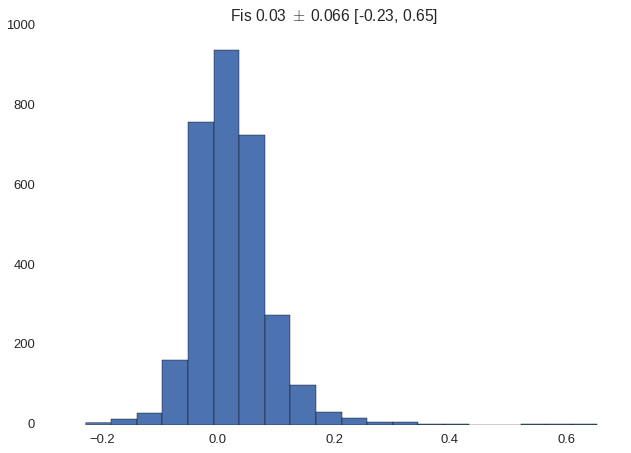

In [24]:
def plot_hist(df, index):
    d = df.ix[index,:]
    plt.hist(d, bins=20)
    plt.title("%s %.2f $\pm$ %.3f [%.2f, %.2f]" % (index, 
                                                   np.mean(d), 
                                                   np.std(d),
                                                  np.min(d),
                                                  np.max(d)))
    plt.show()
plot_hist(af, "Fis")

In [25]:
def convert_to_z12(locus):
    freq = af[locus.name]
    trans = {"%s/%s" % (freq["A"],freq["A"]): 0,
            "%s/%s" % (freq["a"],freq["a"]): 2,
            "%s/%s" % (freq["A"],freq["a"]): 1,
            "%s/%s" % (freq["a"],freq["A"]): 1,
            "?/?":-1}
    return locus.apply(lambda x: trans[x])
z12 = genotypes.apply(convert_to_z12)

In [26]:
def center_and_standardize_value(val, u, var):
    if val == -1:
        return 0.0
    return (val-u)/np.sqrt(var)

def center_and_standardize(snp):
    maf = af.ix["q",snp.name]
    u = np.mean([x for x in snp if x != -1])
    var = np.sqrt(maf*(1-maf))
    return snp.apply(center_and_standardize_value, args=(u, var))

In [27]:
pca_std = z12.apply(center_and_standardize)
pca_std.apply(np.mean)

0-10037-01-257    3.855437e-17
0-10040-02-394   -1.713527e-17
0-10044-01-392    1.285146e-16
0-10048-01-60     4.283819e-17
0-10051-02-166    1.427940e-17
0-10054-01-402   -1.427940e-17
0-10067-03-111   -5.711758e-18
0-10079-02-168    5.140582e-17
0-10112-01-169    2.998673e-17
0-10113-01-119   -8.567637e-17
0-10116-01-165   -7.139698e-18
0-10151-01-86     5.140582e-17
0-10162-01-255    3.569849e-18
0-10207-01-280   -6.282934e-17
0-10210-01-41     0.000000e+00
...
UMN-CL299Contig1-01-46     1.142352e-17
UMN-CL306Contig1-04-261   -8.567637e-18
UMN-CL307Contig1-04-143    3.712643e-17
UMN-CL319Contig1-03-131    1.999115e-17
UMN-CL326Contig1-05-421   -4.569407e-17
UMN-CL339Contig1-05-39    -1.713527e-17
UMN-CL34Contig1-03-89     -9.709989e-17
UMN-CL353Contig1-04-64     1.320844e-17
UMN-CL362Contig1-07-133    3.141467e-17
UMN-CL363Contig1-01-233   -3.284261e-17
UMN-CL379Contig1-12-117   -1.142352e-17
UMN-CL424Contig1-03-94    -5.140582e-17
UMN-CL54Contig1-07-88     -5.426170e-17
UMN-CL91Con

In [28]:
r = ro.r

In [29]:
prcomp = r('prcomp')
summary = r('summary')

In [30]:
prcomp_res = prcomp(pca_std, scale=False, center=False)

In [31]:
print summary(prcomp_res)

Importance of components:
                           PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     6.07193 4.20751 3.79014 3.20076 3.08532 3.04595 2.96424
Proportion of Variance 0.01789 0.00859 0.00697 0.00497 0.00462 0.00450 0.00426
Cumulative Proportion  0.01789 0.02649 0.03346 0.03843 0.04305 0.04755 0.05182
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     2.93988 2.89841 2.88317 2.83414 2.82524 2.80280 2.79039
Proportion of Variance 0.00419 0.00408 0.00403 0.00390 0.00387 0.00381 0.00378
Cumulative Proportion  0.05601 0.06009 0.06412 0.06802 0.07190 0.07571 0.07949
                          PC15    PC16    PC17    PC18    PC19    PC20   PC21
Standard deviation     2.75606 2.74385 2.73991 2.72647 2.71721 2.70782 2.6857
Proportion of Variance 0.00369 0.00365 0.00364 0.00361 0.00358 0.00356 0.0035
Cumulative Proportion  0.08317 0.08683 0.09047 0.09408 0.09766 0.10122 0.1047
                          PC22

In [32]:
x = com.convert_robj(prcomp_res.rx2("x"))
x.index = pca_std.index
x.ix[0:5,0:10]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-4.227659,-0.930500,1.853226,-2.682931,0.923642,-0.432286,2.962403,-1.233186,2.818495,-0.604278
1,0.888892,-0.179881,-8.694134,-2.872412,-3.320970,1.533524,-1.861266,-1.118133,-3.388559,1.083895
2,-3.319852,2.300243,1.670677,-9.666361,-9.595642,4.668615,-20.648915,2.828419,13.892349,6.112814
3,-5.508931,-1.505746,5.299569,5.727700,-4.449550,-0.807838,2.172512,5.269906,5.609469,2.110526
4,-6.334801,-0.261818,6.637892,5.268738,0.579049,-0.522321,0.370901,-3.753941,-0.828416,3.331711
5,-3.629128,-0.334265,2.039921,-3.229526,-1.352967,5.201557,-0.460188,2.400639,-3.360119,0.391390


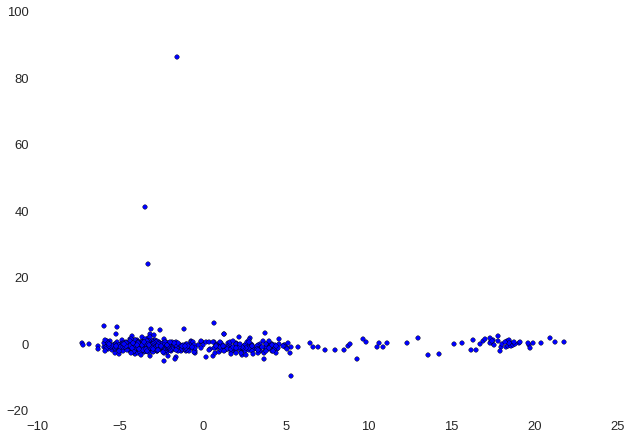

In [33]:
plt.scatter(x.PC1, x.PC2)
plt.show()

In [34]:
%%R
source("tw_calc.R")
test=read.table("twtable", header=F)

In [35]:
TWcalc = r('TWcalc')

In [36]:
tw = TWcalc(com.convert_to_r_matrix(pca_std), 25)

In [37]:
tw_p = com.convert_robj(tw.rx2(2))
tw_e = com.convert_robj(tw.rx2(1))

In [38]:
tw_num = 0
for i, p in enumerate(tw_p):
    print i, p
    if p > 0.05:
        tw_num = i
        break
print "Tracy-Widom test yields %d axes of pop structure" % tw_num

0 8e-09
1 8e-09
2 8e-09
3 8e-09
4 8e-09
5 8e-09
6 8e-09
7 8e-09
8 8e-09
9 8e-09
10 8e-09
11 8e-09
12 8e-09
13 8e-09
14 2.2872e-05
15 0.000220344
16 0.000177359
17 0.00206759
18 0.006211384
19 0.01992964
20 0.328982392
Tracy-Widom test yields 20 axes of pop structure


In [39]:
y = pd.DataFrame(x)
for col in y.columns[0:10]:
    s_cutoff = np.std(y[col])*6
    u = np.mean(y[col])
    cutoff = sorted([u+s_cutoff, u-s_cutoff], reverse=True)
    outliers = y[col][(y[col] > cutoff[0]) | (y[col] < cutoff[1])]
    print col
    print outliers
    y = y.drop(outliers.index)
y.ix[0:5,0:10]

PC1
Series([], name: PC1, dtype: float64)
PC2
348    86.725320
572    41.627337
Name: PC2, dtype: float64
PC3
Series([], name: PC3, dtype: float64)
PC4
596    23.223851
Name: PC4, dtype: float64
PC5
303   -15.047861
Name: PC5, dtype: float64
PC6
9     -32.477463
271   -25.089614
296   -25.141168
603   -22.043115
Name: PC6, dtype: float64
PC7
2     -20.648915
333   -17.148680
391   -17.088184
Name: PC7, dtype: float64
PC8
290   -30.003228
561   -25.400725
Name: PC8, dtype: float64
PC9
578    15.177391
Name: PC9, dtype: float64
PC10
606   -17.195924
Name: PC10, dtype: float64


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-4.227659,-0.930500,1.853226,-2.682931,0.923642,-0.432286,2.962403,-1.233186,2.818495,-0.604278
1,0.888892,-0.179881,-8.694134,-2.872412,-3.320970,1.533524,-1.861266,-1.118133,-3.388559,1.083895
3,-5.508931,-1.505746,5.299569,5.727700,-4.449550,-0.807838,2.172512,5.269906,5.609469,2.110526
4,-6.334801,-0.261818,6.637892,5.268738,0.579049,-0.522321,0.370901,-3.753941,-0.828416,3.331711
5,-3.629128,-0.334265,2.039921,-3.229526,-1.352967,5.201557,-0.460188,2.400639,-3.360119,0.391390


In [40]:
gt_drop = genotypes.ix[y.index,:]

In [41]:
gt_drop[0:10]

,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,0-10207-01-280,0-10210-01-41,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
0,G/G,A/C,G/G,A/A,G/G,A/G,A/A,G/G,A/C,A/A,A/A,A/A,A/A,A/C,?/?,...,A/A,T/T,C/C,A/C,A/G,A/A,C/G,A/A,?/?,G/G,A/A,C/C,G/G,C/C,A/G
1,A/A,C/C,G/G,A/A,G/G,A/G,A/A,A/G,A/A,G/G,A/A,A/A,A/A,A/C,A/A,...,A/A,T/T,C/C,C/C,G/G,A/A,G/G,A/A,A/A,G/G,A/A,A/C,A/G,C/C,A/A
3,A/A,A/A,C/C,G/G,A/G,G/G,A/A,G/G,A/A,A/G,A/A,A/A,A/A,C/C,A/A,...,A/A,T/T,C/C,C/C,G/G,A/A,C/G,A/A,?/?,A/G,A/A,A/C,A/G,C/C,G/G
4,A/A,A/C,C/C,?/?,G/G,A/G,A/A,G/G,A/A,A/A,A/A,A/A,?/?,A/C,?/?,...,A/A,T/T,C/G,C/C,G/G,A/A,C/G,A/A,C/C,A/G,A/A,A/C,G/G,A/C,G/G
5,A/G,C/C,C/G,A/A,G/G,A/G,A/A,G/G,A/A,A/G,A/A,A/A,A/A,C/C,A/A,...,A/A,T/T,C/G,C/C,A/G,A/A,C/G,A/A,?/?,A/G,A/A,A/C,G/G,A/C,A/G
6,A/A,A/A,G/G,A/G,G/G,A/G,A/A,G/G,A/A,A/A,A/A,A/A,A/A,A/A,A/A,...,A/C,T/T,C/G,A/C,G/G,A/A,G/G,A/A,C/C,G/G,A/A,A/C,A/A,C/C,A/G
7,A/G,A/C,C/G,G/G,A/G,A/G,A/A,G/G,A/A,A/G,A/A,A/A,A/A,A/C,A/A,...,A/A,T/T,C/C,A/C,A/G,A/A,C/G,A/A,A/C,A/G,A/A,C/C,A/G,C/C,A/A
8,?/?,A/A,C/C,G/G,G/G,G/G,A/A,G/G,A/A,A/G,?/?,A/A,A/G,A/C,A/A,...,A/A,?/?,C/G,C/C,G/G,A/A,G/G,A/A,?/?,G/G,A/A,A/C,G/G,A/C,A/A
10,A/A,A/A,C/G,G/G,G/G,A/G,A/A,G/G,A/A,A/A,A/A,A/A,A/A,A/A,A/A,...,A/A,T/T,C/C,C/C,A/G,A/A,C/G,A/A,A/C,G/G,A/A,C/C,A/G,C/C,G/G
11,A/A,A/C,?/?,A/G,G/G,A/G,A/A,G/G,A/A,A/G,A/A,A/A,A/A,C/C,A/A,...,A/A,T/T,C/C,A/C,?/?,A/A,G/G,A/A,C/C,G/G,A/A,C/C,A/G,C/C,A/G


In [42]:
gt_drop.shape

(607, 3082)

In [43]:
z12_drop = gt_drop.apply(convert_to_z12)
z12_drop[0:10]

,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,0-10207-01-280,0-10210-01-41,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
0,2,1,2,2,0,1,0,0,1,0,0,0,0,1,-1,...,0,0,0,1,1,0,1,0,-1,0,0,0,0,0,1
1,0,0,2,2,0,1,0,1,0,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2,0,0,1,1,0,2
3,0,2,0,0,1,0,0,0,0,1,0,0,0,2,0,...,0,0,0,0,0,0,1,0,-1,1,0,1,1,0,0
4,0,1,0,-1,0,1,0,0,0,0,0,0,-1,1,-1,...,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0
5,1,0,1,2,0,1,0,0,0,1,0,0,0,2,0,...,0,0,1,0,1,0,1,0,-1,1,0,1,0,1,1
6,0,2,2,1,0,1,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0,0,1,2,0,1
7,1,1,1,0,1,1,0,0,0,1,0,0,0,1,0,...,0,0,0,1,1,0,1,0,1,1,0,0,1,0,2
8,-1,2,0,0,0,0,0,0,0,1,-1,0,1,1,0,...,0,-1,1,0,0,0,0,0,-1,0,0,1,0,1,2
10,0,2,1,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0
11,0,1,-1,1,0,1,0,0,0,1,0,0,0,2,0,...,0,0,0,1,-1,0,0,0,0,0,0,0,1,0,1


In [44]:
pca_drop_std = z12_drop.apply(center_and_standardize)

In [45]:
pca_drop_std.shape

(607, 3082)

In [46]:
pca_drop_std[0:10]

,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,0-10207-01-280,0-10210-01-41,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
0,2.107587,0.047548,1.421714,1.890773,-0.266114,0.011785,-0.179495,-0.173554,1.829378,-0.950368,-0.126562,-0.327354,-0.210419,0.569546,0.00000,...,-0.141186,-0.388627,-0.560743,1.165155,1.034360,-0.2251,0.740705,-0.044142,0.000000,-0.277861,-0.064989,-0.779494,-0.904873,-0.472712,0.877175
1,-0.866951,-1.367010,1.421714,1.890773,-0.266114,0.011785,-0.179495,2.101516,-0.243688,1.968620,-0.126562,-0.327354,-0.210419,0.569546,-0.22353,...,-0.141186,-0.388627,-0.560743,-0.506106,-0.580452,-0.2251,-0.774024,-0.044142,2.041739,-0.277861,-0.064989,0.729526,0.567087,-0.472712,2.434228
3,-0.866951,1.462106,-1.406722,-1.012134,1.729738,-1.402474,-0.179495,-0.173554,-0.243688,0.509126,-0.126562,-0.327354,-0.210419,2.042511,-0.22353,...,-0.141186,-0.388627,-0.560743,-0.506106,-0.580452,-0.2251,0.740705,-0.044142,0.000000,1.686782,-0.064989,0.729526,0.567087,-0.472712,-0.679877
4,-0.866951,0.047548,-1.406722,0.000000,-0.266114,0.011785,-0.179495,-0.173554,-0.243688,-0.950368,-0.126562,-0.327354,0.000000,0.569546,0.00000,...,-0.141186,-0.388627,1.064324,-0.506106,-0.580452,-0.2251,0.740705,-0.044142,-0.900924,1.686782,-0.064989,0.729526,-0.904873,1.229051,-0.679877
5,0.620318,-1.367010,0.007496,1.890773,-0.266114,0.011785,-0.179495,-0.173554,-0.243688,0.509126,-0.126562,-0.327354,-0.210419,2.042511,-0.22353,...,-0.141186,-0.388627,1.064324,-0.506106,1.034360,-0.2251,0.740705,-0.044142,0.000000,1.686782,-0.064989,0.729526,-0.904873,1.229051,0.877175
6,-0.866951,1.462106,1.421714,0.439320,-0.266114,0.011785,-0.179495,-0.173554,-0.243688,-0.950368,-0.126562,-0.327354,-0.210419,-0.903418,-0.22353,...,2.299313,-0.388627,1.064324,1.165155,-0.580452,-0.2251,-0.774024,-0.044142,-0.900924,-0.277861,-0.064989,0.729526,2.039047,-0.472712,0.877175
7,0.620318,0.047548,0.007496,-1.012134,1.729738,0.011785,-0.179495,-0.173554,-0.243688,0.509126,-0.126562,-0.327354,-0.210419,0.569546,-0.22353,...,-0.141186,-0.388627,-0.560743,1.165155,1.034360,-0.2251,0.740705,-0.044142,0.570407,1.686782,-0.064989,-0.779494,0.567087,-0.472712,2.434228
8,0.000000,1.462106,-1.406722,-1.012134,-0.266114,-1.402474,-0.179495,-0.173554,-0.243688,0.509126,0.000000,-0.327354,1.925866,0.569546,-0.22353,...,-0.141186,0.000000,1.064324,-0.506106,-0.580452,-0.2251,-0.774024,-0.044142,0.000000,-0.277861,-0.064989,0.729526,-0.904873,1.229051,2.434228
10,-0.866951,1.462106,0.007496,-1.012134,-0.266114,0.011785,-0.179495,-0.173554,-0.243688,-0.950368,-0.126562,-0.327354,-0.210419,-0.903418,-0.22353,...,-0.141186,-0.388627,-0.560743,-0.506106,1.034360,-0.2251,0.740705,-0.044142,0.570407,-0.277861,-0.064989,-0.779494,0.567087,-0.472712,-0.679877
11,-0.866951,0.047548,0.000000,0.439320,-0.266114,0.011785,-0.179495,-0.173554,-0.243688,0.509126,-0.126562,-0.327354,-0.210419,2.042511,-0.22353,...,-0.141186,-0.388627,-0.560743,1.165155,0.000000,-0.2251,-0.774024,-0.044142,-0.900924,-0.277861,-0.064989,-0.779494,0.567087,-0.472712,0.877175


In [47]:
pca_drop_std.describe().ix[:,0:5]

,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166
count,6.070000e+02,6.070000e+02,6.070000e+02,6.070000e+02,6.070000e+02
mean,5.852906e-17,-1.755872e-17,4.682324e-17,-4.389679e-18,8.779358e-18
std,9.303810e-01,9.941637e-01,1.009829e+00,1.021606e+00,7.036968e-01
min,-8.669507e-01,-1.367010e+00,-1.406722e+00,-1.012134e+00,-2.661136e-01
25%,-8.669507e-01,-1.367010e+00,-1.406722e+00,-1.012134e+00,-2.661136e-01
50%,0.000000e+00,4.754816e-02,7.495854e-03,4.393196e-01,-2.661136e-01
75%,6.203181e-01,4.754816e-02,1.421714e+00,4.393196e-01,-2.661136e-01
max,2.107587e+00,1.462106e+00,1.421714e+00,1.890773e+00,3.725590e+00


In [48]:
prcomp_res_drop = prcomp(pca_drop_std, scale=False, center=False)

In [49]:
x_drop = com.convert_robj(prcomp_res_drop.rx2("x"))
x_drop.index = pca_drop_std.index
x_drop.ix[0:5,0:5]

,PC1,PC2,PC3,PC4,PC5
0,-4.333631,1.477887,2.473628,-2.610228,3.732781
1,0.972361,-8.577780,2.513130,8.103148,2.426614
3,-5.587363,4.702591,-5.712560,1.822264,-5.001879
4,-6.356667,6.632884,-6.070111,-0.607114,4.199792
5,-3.653699,2.052517,5.030496,2.775605,6.097295


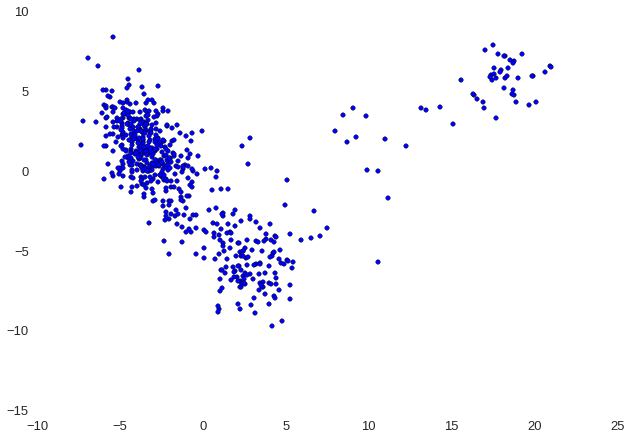

In [50]:
plt.scatter(x_drop.PC1, x_drop.PC2)
plt.show()

In [51]:
print summary(prcomp_res_drop)

Importance of components:
                           PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     6.04309 3.80099 3.14407 2.95914 2.89047 2.85444 2.82015
Proportion of Variance 0.01799 0.00712 0.00487 0.00431 0.00412 0.00401 0.00392
Cumulative Proportion  0.01799 0.02511 0.02998 0.03430 0.03841 0.04243 0.04635
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     2.80660 2.79209 2.78734 2.77330 2.76292 2.74726 2.73089
Proportion of Variance 0.00388 0.00384 0.00383 0.00379 0.00376 0.00372 0.00367
Cumulative Proportion  0.05023 0.05407 0.05790 0.06169 0.06545 0.06917 0.07284
                          PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     2.70648 2.70016 2.69946 2.69158 2.68432 2.68015 2.66814
Proportion of Variance 0.00361 0.00359 0.00359 0.00357 0.00355 0.00354 0.00351
Cumulative Proportion  0.07645 0.08004 0.08364 0.08720 0.09076 0.09429 0.09780
                         P

In [52]:
tw = TWcalc(com.convert_to_r_matrix(pca_drop_std), 25)

In [53]:
tw_p = com.convert_robj(tw.rx2(2))
tw_e = com.convert_robj(tw.rx2(1))

In [54]:
tw_num = 0
for i, p in enumerate(tw_p):
    print i, p
    if p > 0.05:
        tw_num = i
        break
print "Tracy-Widom test yields %d axes of pop structure" % tw_num

0 8e-09
1 8e-09
2 8e-09
3 8e-09
4 8e-09
5 8e-09
6 8e-09
7 5.9e-08
8 1.501e-06
9 1.501e-06
10 2.8955e-05
11 0.000177359
12 0.003013114
13 0.042180992
14 0.573774198
Tracy-Widom test yields 14 axes of pop structure


In [55]:
hierf_trans = {0:11, 1:12, 2:22, -1:'NA'}

In [56]:
def apply_hierf_trans(series):
    return [hierf_trans[x] if x in hierf_trans else x for x in series]

In [57]:
hierf_df = z12_drop.apply(apply_hierf_trans)

In [58]:
hierf_df.shape

(607, 3082)

In [59]:
hierf_df.insert(0, "countyid", None)
hierf_df[0:5]

,countyid,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,0-10207-01-280,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
0,None,22,12,22,22,11,12,11,11,12,11,11,11,11,12,...,11,11,11,12,12,11,12,11,NA,11,11,11,11,11,12
1,None,11,11,22,22,11,12,11,12,11,22,11,11,11,12,...,11,11,11,11,11,11,11,11,22,11,11,12,12,11,22
3,None,11,22,11,11,12,11,11,11,11,12,11,11,11,22,...,11,11,11,11,11,11,12,11,NA,12,11,12,12,11,11
4,None,11,12,11,NA,11,12,11,11,11,11,11,11,NA,12,...,11,11,12,11,11,11,12,11,11,12,11,12,11,12,11
5,None,12,11,12,22,11,12,11,11,11,12,11,11,11,22,...,11,11,12,11,12,11,12,11,NA,12,11,12,11,12,12


In [60]:
loc_hierf = data_loc.join(hierf_df, how="inner")
bayenv_df = loc_hierf.copy()

In [61]:
print hierf_df.shape, data_loc.shape, loc_hierf.shape, bayenv_df.shape

(607, 3083) (622, 4) (607, 3087) (607, 3087)


In [62]:
loc_hierf['county_state'] = loc_hierf.apply(lambda row: "%s_%s" % (row.county, row.state), axis=1)
usable_counties = set()
county_counts = loc_hierf.county_state.value_counts()
county_counts = county_counts.sort(inplace=False, ascending=False)
for c in county_counts.index:
    print c, county_counts[c]
for c in county_counts.index:
    if county_counts[c] >=5:
        usable_counties.add(c)
usable_counties = sorted(list(usable_counties))

TUSCALOOSA_AL 63
BEAUFORT_NC 36
CRAVEN_NC 23
PICKENS_AL 17
GREENE_AL 17
CHOCTAW_AL 13
MARION_FL 13
ONSLOW_NC 13
BRUNSWICK_NC 11
LEVY_FL 11
NEWBERRY_SC 11
HERTFORD_NC 10
GEORGETOWN_SC 10
PRINCE GEORGE_VA 9
ANSON_NC 9
BRUNSWICK_VA 8
MECKLENBURG_VA 8
DINWIDDIE_VA 8
BERKELEY_SC 7
WAKE_NC 7
BERTIE_NC 7
SUMTER_AL 7
McCURTAIN_OK 7
WILCOX_AL 7
MARENGO_AL 6
CLARKE_AL 6
MARTIN_NC 6
JASPER_MS 6
HALIFAX_NC 6
COLUMBUS_NC 6
CHESTERFIELD_VA 5
SUSSEX_VA 5
SPOTSYLVANIA_VA 5
CLEVELAND_AR 5
HALE_AL 4
POLK_TX 4
LAMAR_AL 4
HALIFAX_VA 4
KING & QUEEN_VA 4
RICHMOND_NC 4
FLUVANNA_VA 4
SALUDA_SC 4
MOORE_NC 4
FRANKLIN_NC 3
GATES_NC 3
CALHOUN_AL 3
CUMBERLAND_VA 3
CLARKE_MS 3
CHOWAN_NC 3
WINSTON_AL 3
HOUSTON_TX 3
TYRRELL_NC 3
CALHOUN_AR 3
LUNENBURG_VA 3
GREENWOOD_SC 3
JONES_NC 3
BIBB_AL 3
JASPER_SC 3
NEW KENT_VA 3
WARREN_NC 3
DURHAM_NC 2
NORTHAMPTON_NC 2
FAYETTE_AL 2
BAMBERG_SC 2
YORK_SC 2
BARTOW_GA 2
MARSHALL_AL 2
CONECUH_AL 2
LEE_NC 2
CHATTOOGA_GA 2
PASQUOTANK_NC 2
UNION_SC 2
ROWAN_NC 2
DORCHESTER_SC 2
DALLAS_AL

In [63]:
county_id = {}
for i, county in enumerate(usable_counties):
    county_id[county] = i+1
county_id


{u'ANSON_NC': 1,
 u'BEAUFORT_NC': 2,
 u'BERKELEY_SC': 3,
 u'BERTIE_NC': 4,
 u'BRUNSWICK_NC': 5,
 u'BRUNSWICK_VA': 6,
 u'CHESTERFIELD_VA': 7,
 u'CHOCTAW_AL': 8,
 u'CLARKE_AL': 9,
 u'CLEVELAND_AR': 10,
 u'COLUMBUS_NC': 11,
 u'CRAVEN_NC': 12,
 u'DINWIDDIE_VA': 13,
 u'GEORGETOWN_SC': 14,
 u'GREENE_AL': 15,
 u'HALIFAX_NC': 16,
 u'HERTFORD_NC': 17,
 u'JASPER_MS': 18,
 u'LEVY_FL': 19,
 u'MARENGO_AL': 20,
 u'MARION_FL': 21,
 u'MARTIN_NC': 22,
 u'MECKLENBURG_VA': 23,
 u'McCURTAIN_OK': 24,
 u'NEWBERRY_SC': 25,
 u'ONSLOW_NC': 26,
 u'PICKENS_AL': 27,
 u'PRINCE GEORGE_VA': 28,
 u'SPOTSYLVANIA_VA': 29,
 u'SUMTER_AL': 30,
 u'SUSSEX_VA': 31,
 u'TUSCALOOSA_AL': 32,
 u'WAKE_NC': 33,
 u'WILCOX_AL': 34}

In [64]:
loc_hierf['usable'] = loc_hierf.apply(lambda row: row.county_state in county_id, axis=1)

In [65]:
drop = loc_hierf[loc_hierf.usable==False]

In [66]:
loc_hierf = loc_hierf.drop(drop.index)

In [67]:
loc_hierf

,county,state,lat,long,countyid,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,...,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig,county_state,usable
8,COLUMBUS,NC,34.33010,-78.70453,NaN,NA,22,11,11,11,11,11,11,11,12,...,12,11,11,11,11,11,NA,11,11,12,11,12,22,COLUMBUS_NC,True
10,ONSLOW,NC,34.75963,-77.40977,NaN,11,22,12,11,11,12,11,11,11,11,...,11,11,12,11,12,11,12,11,11,11,12,11,11,ONSLOW_NC,True
11,ONSLOW,NC,34.75963,-77.40977,NaN,11,12,NA,12,11,12,11,11,11,12,...,11,12,NA,11,11,11,11,11,11,11,12,11,12,ONSLOW_NC,True
12,GEORGETOWN,SC,33.36318,-79.30539,NaN,NA,12,NA,NA,11,12,11,11,12,12,...,12,NA,12,11,NA,11,12,11,11,11,NA,11,NA,GEORGETOWN_SC,True
13,BEAUFORT,NC,35.55349,-77.05205,NaN,11,NA,12,12,11,22,11,11,11,12,...,11,11,11,11,11,11,12,11,11,22,11,12,11,BEAUFORT_NC,True
14,BERTIE,NC,35.99815,-76.94897,NaN,12,12,11,11,11,12,11,11,11,11,...,11,12,11,12,12,11,12,11,11,11,12,11,11,BERTIE_NC,True
15,CRAVEN,NC,35.10917,-77.06917,NaN,12,12,12,12,11,12,11,11,11,22,...,11,11,11,11,12,11,12,12,11,11,12,11,11,CRAVEN_NC,True
16,ONSLOW,NC,34.75963,-77.40977,NaN,11,11,11,11,11,22,12,11,12,11,...,11,12,11,11,11,11,12,11,11,11,11,11,11,ONSLOW_NC,True
18,BEAUFORT,NC,35.55349,-77.05205,NaN,11,11,22,11,12,12,11,11,11,12,...,11,11,11,12,11,11,NA,11,11,12,11,11,11,BEAUFORT_NC,True
20,CRAVEN,NC,35.10917,-77.06917,NaN,11,12,12,22,11,22,11,12,11,11,...,12,11,12,11,12,11,11,11,12,11,12,22,11,CRAVEN_NC,True


In [68]:
loc_hierf['countyid'] = loc_hierf.apply(lambda row: county_id[row.county_state], axis=1)

In [69]:
loc_hierf[0:10]

,county,state,lat,long,countyid,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,...,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig,county_state,usable
8,COLUMBUS,NC,34.33010,-78.70453,11,NA,22,11,11,11,11,11,11,11,12,...,12,11,11,11,11,11,NA,11,11,12,11,12,22,COLUMBUS_NC,True
10,ONSLOW,NC,34.75963,-77.40977,26,11,22,12,11,11,12,11,11,11,11,...,11,11,12,11,12,11,12,11,11,11,12,11,11,ONSLOW_NC,True
11,ONSLOW,NC,34.75963,-77.40977,26,11,12,NA,12,11,12,11,11,11,12,...,11,12,NA,11,11,11,11,11,11,11,12,11,12,ONSLOW_NC,True
12,GEORGETOWN,SC,33.36318,-79.30539,14,NA,12,NA,NA,11,12,11,11,12,12,...,12,NA,12,11,NA,11,12,11,11,11,NA,11,NA,GEORGETOWN_SC,True
13,BEAUFORT,NC,35.55349,-77.05205,2,11,NA,12,12,11,22,11,11,11,12,...,11,11,11,11,11,11,12,11,11,22,11,12,11,BEAUFORT_NC,True
14,BERTIE,NC,35.99815,-76.94897,4,12,12,11,11,11,12,11,11,11,11,...,11,12,11,12,12,11,12,11,11,11,12,11,11,BERTIE_NC,True
15,CRAVEN,NC,35.10917,-77.06917,12,12,12,12,12,11,12,11,11,11,22,...,11,11,11,11,12,11,12,12,11,11,12,11,11,CRAVEN_NC,True
16,ONSLOW,NC,34.75963,-77.40977,26,11,11,11,11,11,22,12,11,12,11,...,11,12,11,11,11,11,12,11,11,11,11,11,11,ONSLOW_NC,True
18,BEAUFORT,NC,35.55349,-77.05205,2,11,11,22,11,12,12,11,11,11,12,...,11,11,11,12,11,11,NA,11,11,12,11,11,11,BEAUFORT_NC,True
20,CRAVEN,NC,35.10917,-77.06917,12,11,12,12,22,11,22,11,12,11,11,...,12,11,12,11,12,11,11,11,12,11,12,22,11,CRAVEN_NC,True


In [70]:
loc_hierf.shape

(388, 3089)

In [71]:
sorted(loc_hierf.countyid.unique())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34]

In [72]:
loc_hierf.ix[:,4:-2].to_csv("hierf.txt", sep="\t", header=True, index=False)

In [73]:
%%R
# library(hierfstat)
# data = read.table("hierf.txt", header=T, sep="\t")
# data = data[order(data$countyid),]
# levels = data.frame(data$countyid)
# loci = data[,2:ncol(data)]
# bs = basic.stats(data)
# saveRDS(bs, "basic_stats.rds")
# res = varcomp.glob(levels=levels, loci=loci, diploid=T)
# saveRDS(res, "hierf.rds")

NULL


In [74]:
%%R
bs = readRDS("basic_stats.rds")
res = readRDS("hierf.rds")

In [75]:
res = com.convert_robj(ro.r('res'))

In [76]:
bs = com.convert_robj(ro.r('bs'))
Fis = bs['Fis']
Hs = bs['Hs']
pop_freq_temp = bs['pop.freq']
pop_freq = {}
perloc = bs['perloc']
n_ind_samp = bs['n.ind.samp']
Ho = bs['Ho']
overall = bs['overall']

for df in [Fis, Hs, perloc, n_ind_samp, Ho]:
    df.index = [x[1:].replace(".","-") for x in df.index]

for locus, data in pop_freq_temp.items():
    if len(data) == 2:
        data.index = ['p','q']
    else:
        data.index = ['p']
    pop_freq[locus[1:].replace(".", "-")] = data

Ho = Ho.T
perloc = perloc.T
n_ind_samp = n_ind_samp.T
Hs = Hs.T
Fis = Fis.T

In [77]:
Ho

,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,0-10207-01-280,0-10210-01-41,...,MN-CL299Contig1-01-46,MN-CL306Contig1-04-261,MN-CL307Contig1-04-143,MN-CL319Contig1-03-131,MN-CL326Contig1-05-421,MN-CL339Contig1-05-39,MN-CL34Contig1-03-89,MN-CL353Contig1-04-64,MN-CL362Contig1-07-133,MN-CL363Contig1-01-233,MN-CL379Contig1-12-117,MN-CL424Contig1-03-94,MN-CL54Contig1-07-88,MN-CL91Contig1-02-246,MN-CL97Contig
1,0.2222,0.1111,0.4444,0.5556,0.0000,0.5556,0.0000,0.1111,0.1111,0.5556,0.1111,0.1111,0.1111,0.5556,0.0000,...,0.0000,0.0000,0.3333,0.2222,0.2222,0.1111,0.2857,0.0000,0.2500,0.3333,0.0000,0.4444,0.4444,0.6667,0.4444
2,0.2059,0.4194,0.5714,0.3824,0.0606,0.5312,0.0571,0.0278,0.2000,0.5152,0.0278,0.0857,0.0571,0.3333,0.1714,...,0.0278,0.0606,0.4062,0.2647,0.1875,0.2286,0.3235,0.0278,0.5357,0.1389,0.0278,0.4706,0.3611,0.2353,0.4118
3,0.1429,0.8571,0.4286,0.2857,0.1429,0.4286,0.0000,0.1429,0.0000,0.4286,0.0000,0.2857,0.0000,0.2857,0.0000,...,0.0000,0.4286,0.2857,0.1429,0.3333,0.1429,0.1429,0.0000,0.5000,0.0000,0.0000,0.5714,0.2857,0.1429,0.5714
4,0.6667,0.7143,0.5000,0.1667,0.0000,0.7143,0.0000,0.0000,0.2857,0.2857,0.0000,0.1429,0.1429,0.7143,0.0000,...,0.1429,0.2857,0.1667,0.2857,0.5000,0.1429,0.4286,0.0000,0.3333,0.0000,0.0000,0.7143,0.5714,0.1429,0.1429
5,0.4545,0.7778,0.7273,0.5000,0.1000,0.6000,0.0000,0.0000,0.1818,0.4545,0.0000,0.0000,0.0000,0.5455,0.1000,...,0.0000,0.0000,0.4545,0.0000,0.4000,0.0000,0.5455,0.0000,0.4000,0.2727,0.0000,0.3636,0.7273,0.4545,0.1000
6,0.6250,0.6250,0.2500,0.5000,0.2500,0.8750,0.0000,0.1250,0.0000,0.3750,0.0000,0.1250,0.0000,0.1250,0.0000,...,0.0000,0.1250,0.3750,0.2500,0.4286,0.1250,0.5000,0.0000,0.5000,0.1250,0.0000,0.5000,0.1250,0.2500,0.3750
7,0.4000,0.4000,0.5000,0.6000,0.2000,0.4000,0.0000,0.0000,0.4000,0.4000,0.2000,0.0000,0.0000,0.6000,0.2000,...,0.0000,0.0000,0.6000,0.4000,0.2000,0.2000,0.4000,0.0000,0.0000,0.2000,0.0000,0.2000,0.6000,0.0000,0.0000
8,0.4615,0.7692,0.5833,0.4615,0.0769,0.5385,0.1538,0.0769,0.0000,0.4615,0.0000,0.0769,0.0000,0.1538,0.1667,...,0.0769,0.1538,0.2308,0.3846,0.4615,0.3077,0.3846,0.0000,0.7273,0.1538,0.0000,0.2308,0.3077,0.3077,0.3846
9,0.1667,0.6667,0.5000,0.1667,0.0000,0.4000,0.0000,0.1667,0.3333,0.3333,0.0000,0.0000,0.1667,0.5000,0.2000,...,0.0000,0.6667,0.3333,0.1667,0.1667,0.0000,0.4000,0.0000,0.8000,0.1667,0.0000,0.3333,0.3333,0.1667,0.4000
10,0.6000,0.7500,0.8000,0.2000,0.0000,0.4000,0.2000,0.0000,0.0000,0.4000,0.0000,0.0000,0.2000,0.2000,0.0000,...,0.0000,0.2500,0.0000,0.0000,0.0000,0.0000,0.8000,0.0000,0.5000,0.0000,0.0000,0.2000,0.5000,0.0000,0.2000


In [78]:
perloc['0-10037-01-257']

Ho      0.4312
Hs      0.4181
Ht      0.4139
Dst    -0.0043
Htp     0.4137
Dstp   -0.0044
Fst    -0.0103
Fstp   -0.0106
Fis    -0.0313
Dest   -0.0075
Name: 0-10037-01-257, dtype: float64

In [80]:
af['0-10037-01-257']

A                         A
Fis             -0.03216907
He                0.4090983
Ho                0.4222586
P                       872
PQ                      258
Q                       350
a                         G
num_indiv               611
p                 0.7135843
q                 0.2864157
total_alleles          1222
Name: 0-10037-01-257, dtype: object

In [81]:
loc_df = res['loc']
F_df = res['F']
overall_df = res['overall']

In [82]:
F_df

,data.countyid,Ind
Total,0.009032,0.014992
data.countyid,0.000000,0.006014


In [83]:
def compute_fst(series):
    Va = series[0]
    Vt = sum(series)
    return Va/Vt

In [84]:
loci_fst = loc_df.apply(compute_fst, axis=1).dropna()
loci_fst.index = [x[1:].replace(".", "-") for x in loci_fst.index]

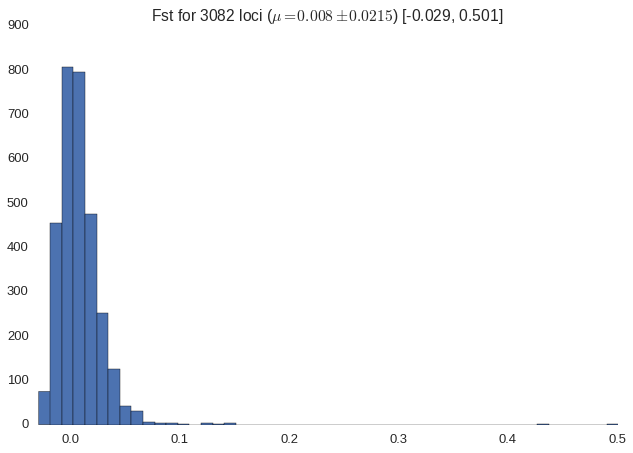

In [85]:
plt.hist(loci_fst, bins=50)
plt.xlim(-.03, .5)
plt.title("Fst for %d loci ($\mu=%.3f \pm %.4f$) [%.3f, %.3f]" % (len(loci_fst),
                                                                  np.mean(loci_fst),
                                                                  np.std(loci_fst),
                                                                  np.min(loci_fst),
                                                                  np.max(loci_fst)))
plt.show()

In [86]:
loc_hierf.shape

(388, 3089)

In [87]:
trait = loc_hierf.apply(get_phenotype, axis=1)

In [88]:
trait_loc_hierf = trait.join(loc_hierf, how="inner")

In [89]:
trait_complete = trait_loc_hierf.drop(trait_loc_hierf[np.isnan(trait_loc_hierf[trait_name])].index)

In [90]:
trait_complete[:5]

,Longitude,Latitude,Clone_id,sucrose,county,state,lat,long,countyid,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,...,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig,county_state,usable
8,-78.70453,34.33010,153B,5.578561,COLUMBUS,NC,34.33010,-78.70453,11,NA,22,11,11,11,11,...,12,11,11,11,11,11,NA,11,11,12,11,12,22,COLUMBUS_NC,True
12,-79.30539,33.36318,90C,5.718644,GEORGETOWN,SC,33.36318,-79.30539,14,NA,12,NA,NA,11,12,...,12,NA,12,11,NA,11,12,11,11,11,NA,11,NA,GEORGETOWN_SC,True
13,-77.05205,35.55349,382A,5.591146,BEAUFORT,NC,35.55349,-77.05205,2,11,NA,12,12,11,22,...,11,11,11,11,11,11,12,11,11,22,11,12,11,BEAUFORT_NC,True
15,-77.06917,35.10917,383C,5.492224,CRAVEN,NC,35.10917,-77.06917,12,12,12,12,12,11,12,...,11,11,11,11,12,11,12,12,11,11,12,11,11,CRAVEN_NC,True
18,-77.05205,35.55349,382A,5.591146,BEAUFORT,NC,35.55349,-77.05205,2,11,11,22,11,12,12,...,11,11,11,12,11,11,NA,11,11,12,11,11,11,BEAUFORT_NC,True


In [91]:
trait_complete.shape

(330, 3093)

In [92]:
def convert_to_snpassoc(col):
    if "-" in col.name:
        freqs = af[col.name]
        trans = {11: "%s/%s" % (freqs["A"], freqs["A"]),
                12: "%s/%s" % (freqs["A"], freqs["a"]),
                22: "%s/%s" % (freqs["a"], freqs["a"]),
                "NA":"NA"}
        return col.apply(lambda x: trans[x])
    return col
trait_snpassoc = trait_complete.apply(convert_to_snpassoc)

In [93]:
pca_cov = x_drop.ix[:,0:14]

In [94]:
trait_snpassoc_pca = trait_snpassoc.join(pca_cov, how="inner")

In [95]:
trait_snpassoc_pca = trait_snpassoc_pca.drop(['county_state',
                                                   'usable',
                                                   'Longitude',
                                                   'Latitude',
                                                   'Clone_id',
                                                   'county',
                                                   'state',
                                                   'lat',
                                                   'long',
                                                   'countyid'], axis=1)

In [96]:
trait_snpassoc_pca[0:10]

,sucrose,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,0-10207-01-280,...,UMN-CL97Contig,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
8,5.578561,NA,A/A,C/C,G/G,G/G,G/G,A/A,G/G,A/A,A/G,NA,A/A,A/G,A/C,...,A/A,-3.639308,1.929420,1.193841,-3.447265,0.971588,1.904022,-2.019537,4.332102,-2.889919,1.682956,-6.441526,4.149832,-0.223308,-0.780265
12,5.718644,NA,C/A,NA,NA,G/G,G/A,A/A,G/G,A/C,A/G,A/C,A/A,A/A,A/A,...,NA,2.329722,1.624366,0.335046,-0.417052,-1.013743,-0.138149,1.068138,0.402887,-0.010373,0.559439,2.445590,0.335334,-0.047097,-1.344021
13,5.591146,A/A,NA,C/G,G/A,G/G,A/A,A/A,G/G,A/A,A/G,A/A,A/A,A/A,C/C,...,G/G,-2.708652,3.668354,4.708462,0.815316,5.354841,5.688271,6.544227,1.869980,-0.408042,2.274323,0.627999,-6.249547,-8.086907,8.983447
15,5.492224,A/G,C/A,C/G,G/A,G/G,G/A,A/A,G/G,A/A,G/G,A/C,A/T,A/A,C/C,...,G/G,-3.152409,2.664518,2.302811,-0.078610,0.237071,-3.257392,-2.636748,3.809404,-0.443443,7.257342,-0.466697,1.824831,-0.198020,-1.268526
18,5.591146,A/A,C/C,G/G,G/G,G/A,G/A,A/A,G/G,A/A,A/G,A/A,A/A,A/A,A/A,...,G/G,-3.806482,2.723616,-5.248239,-2.665990,4.428649,-2.327034,-2.104905,5.450938,-3.403810,-0.727319,4.328464,-1.099518,0.683061,0.534313
20,5.492224,A/A,C/A,C/G,A/A,G/G,A/A,A/A,G/A,A/A,A/A,A/A,A/A,A/A,A/C,...,G/G,-3.674586,5.344520,-3.761804,-0.478603,1.534471,-8.286508,0.466899,-0.567112,0.364850,-1.035324,-3.491548,-1.579615,3.806241,-2.126386
21,5.492224,A/A,C/A,C/C,G/A,G/G,G/A,A/A,G/G,A/A,A/G,A/A,A/A,A/A,A/C,...,G/G,-3.751640,1.047446,2.527706,0.383311,1.258178,-1.602399,-1.049422,-0.513667,0.813623,-3.173031,3.134579,-1.376190,-3.413124,0.899154
24,5.492224,A/A,A/A,C/C,G/G,G/G,G/A,A/A,G/G,A/A,A/A,A/A,A/A,A/A,A/A,...,G/G,-4.243603,2.818623,-0.340036,-2.954661,1.515424,-3.745098,-0.131087,-1.287536,1.850114,-4.802101,2.334467,1.679421,-2.270278,-0.127229
25,5.591146,A/A,C/A,NA,G/G,G/G,A/A,A/A,G/G,A/C,A/G,A/A,A/T,A/A,C/C,...,G/G,-3.540567,1.402466,5.500744,-3.573384,1.453907,-2.465346,-1.806674,-1.587390,-0.767331,0.265662,-1.329243,-1.248258,0.659197,2.035803
26,5.591146,A/A,C/C,C/C,G/G,G/G,G/A,A/A,G/G,A/A,A/G,A/A,A/A,A/A,A/A,...,G/A,3.738074,-7.598378,-2.400551,1.107317,2.126793,-3.917600,-1.719408,4.265561,-0.418051,-0.352412,0.283295,-1.652070,2.133209,-2.821890


In [97]:
trait_snpassoc.shape

(330, 3093)

In [98]:
trait_snpassoc_pca.to_csv("snpassoc.txt",
                             header=True,
                             index=True,
                             sep="\t")

In [99]:
def write_snpassoc_file(df, input_file, num_pca_axes):
    pheno = df.columns[0:1]
    out_files = []
    for p in pheno:
        with open("snpassoc_%s.R" % p.lower(), "w") as o:
            print "writing %s" % o.name
            out_files.append(o.name)
            text = '''
library(SNPassoc)

d = read.table('%s', sep="\\t", row.names=1, header=T)

#subtract b/c those are the PCA axes
snp_cols = 2:(ncol(d)-%d)
snp_data = setupSNP(d, colSNPs=snp_cols, sep="/")
pca_cols = (ncol(d)-%d):ncol(d)
pca_data = d[,pca_cols]

wg = WGassociation(%s~1+pca_data$PC1+pca_data$PC2+pca_data$PC3+pca_data$PC4+
pca_data$PC5+pca_data$PC6+pca_data$PC7+pca_data$PC8+pca_data$PC9+pca_data$PC10+
+pca_data$PC11+pca_data$PC12+pca_data$PC13+pca_data$PC14, 
data=snp_data, 
model="co", 
genotypingRate=5)

saveRDS(wg, "wg_%s_co.rds")
stats = WGstats(wg)
saveRDS(stats, "wgstats_%s.rds")
''' % (input_file, 
       num_pca_axes,
       num_pca_axes-1,
       p, 
       p.lower(), 
       p.lower())
        
            o.write(text)
    return out_files

In [100]:
write_snpassoc_file(trait_snpassoc_pca, "snpassoc.txt", 14)

writing snpassoc_sucrose.R


[u'snpassoc_sucrose.R']

##Run this in R
```R
source("snpassoc_<trait>.R")
```

In [101]:
%%R
wg_trait_co.rds = readRDS('wg_sucrose_co.rds')
wgstats_trait.rds = readRDS('wgstats_sucrose.rds')

In [102]:
wgstats_trait = r['wgstats_trait.rds']
wgstats_trait_labels = r('labels(wg_trait_co.rds)')

In [103]:
wgstats = {trait_name:[wgstats_trait, wgstats_trait_labels.rx2(1)]}
for key, datalist in wgstats.items():
    print "converting %s" % key
    wgstats[key] = [com.convert_robj(x) for x in datalist]

converting sucrose


In [104]:
def get_alleles(data):
    a = set()
    for x in data.index:
        for elem in x.split("/"):
            a.add(elem)
    return list(a)  

def get_allele_freqs_wg(data, AA, Aa, aa):
    total = np.sum(data['n'])*2
    A = data.ix[AA, "n"]*2 + data.ix[Aa, "n"]
    a = data.ix[aa, "n"]*2 + data.ix[Aa, "n"]
    return A/total, a/total

def get_genotypes(data, alleles):
    homos = ["%s/%s" % (x,x) for x in alleles]
    Aa = "%s/%s" % (alleles[0], alleles[1])
    if Aa not in data.index:
        Aa = Aa[::-1] #reverse it
    AA, aa = homos
    if data.ix[AA, "n"] < data.ix[aa, "n"]:
        AA, aa = homos[::-1] #reverse it so that major is first
    return AA, Aa, aa

def get_genotypic_values(data, alleles):
    AA, Aa, aa = get_genotypes(data, alleles)
    G_AA = float(data.ix[AA, 'me'])
    G_aa = float(data.ix[aa, 'me'])
    additive = (G_AA-G_aa)/2
    G_Aa = float(data.ix[Aa, 'me'])
    dominance = G_Aa - ((G_AA+G_aa)/2)
    return additive, dominance, AA, Aa, aa
    
def get_alpha(data):
    alleles = get_alleles(data)
    additive, dominance, AA, Aa, aa = get_genotypic_values(data, alleles)
    p, q = get_allele_freqs_wg(data, AA, Aa, aa)
    alpha = additive + (dominance*(q-p))
    return alpha, AA, aa, p, q

In [105]:
alpha_vals = {}
for p in wgstats:
    print "running %s" % p
    df = pd.DataFrame(index=["alpha", "p-value", "AA", "aa", "p", "q"])
    alpha_vals[p] = df
    d = wgstats[p][0]
    labels = wgstats[p][1]
    for i, locus in enumerate(d):
        try:
            data = pd.DataFrame(d[locus])
            snp = labels[i]
            genotypes = [g for g in data.index if "/" in g]
            data = data.ix[genotypes,:]
            pvalue = data['p-value'].dropna()[0]
            if len(genotypes) == 3:
                alpha, AA, aa, p, q = get_alpha(data)
                df[snp] = [alpha, pvalue, AA, aa, p, q]
        except Exception as e: 
            pass

running sucrose


In [106]:
alpha_vals[trait_name].ix[:,0:10]

,X0.10037.01.257,X0.10040.02.394,X0.10044.01.392,X0.10048.01.60,X0.10051.02.166,X0.10054.01.402,X0.10079.02.168,X0.10112.01.169,X0.10113.01.119,X0.10116.01.165
alpha,-0.004097739,-0.00181165,-0.0002803176,0.0279112,-0.003872464,0.02172985,0.04191577,-0.003347441,0.003736298,0.02158743
p-value,0.8362344,0.9471765,0.6266669,0.07377968,0.7658862,0.9580188,0.422769,0.3233936,0.6388786,0.2011802
AA,G/G,T/T,G/G,A/A,A/A,G/G,A/A,A/A,C/C,G/G
aa,A/A,A/A,A/A,C/C,G/G,A/A,G/G,G/G,G/G,C/C
p,0.7299383,0.6554878,0.9542683,0.8953846,0.8611111,0.9832827,0.9542587,0.9557927,0.781155,0.859375
q,0.2700617,0.3445122,0.04573171,0.1046154,0.1388889,0.01671733,0.04574132,0.04420732,0.218845,0.140625


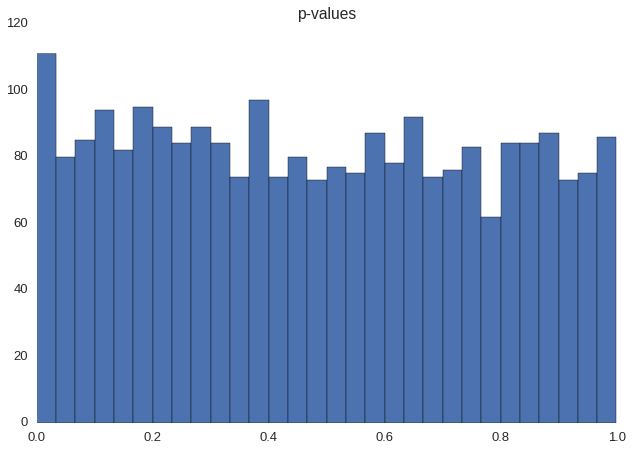

In [107]:
plt.hist(alpha_vals[trait_name].ix['p-value',:], bins=30)
plt.title("p-values")
plt.show()

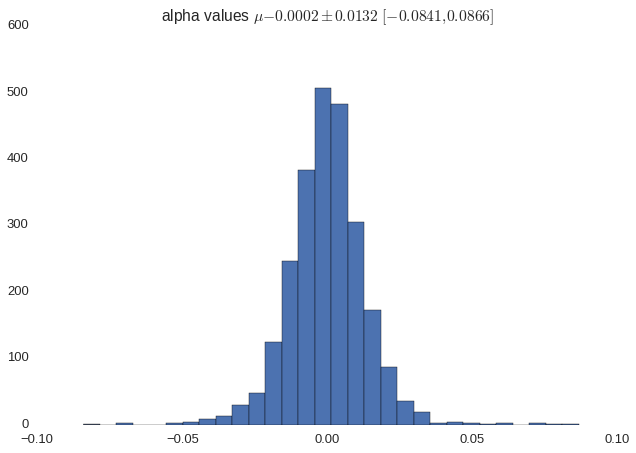

In [108]:
plt.hist(alpha_vals[trait_name].ix['alpha',:], bins=30)
plt.title("alpha values $\mu %.4f \pm %.4f \ [%.4f, %.4f]$" % (np.mean(alpha_vals[trait_name].ix['alpha',:]),
                                                            np.std(alpha_vals[trait_name].ix['alpha',:]),
                                                            np.min(alpha_vals[trait_name].ix['alpha',:]),
                                                             np.max(alpha_vals[trait_name].ix['alpha',:])))
plt.show()

In [109]:
trait_snpassoc_pca_county = pd.concat([loc_hierf.countyid, trait_snpassoc_pca], axis=1)
trait_snpassoc_pca_county = trait_snpassoc_pca_county.drop(trait_snpassoc_pca_county[np.isnan(trait_snpassoc_pca_county[trait_name])].index)
trait_snpassoc_pca_county[0:5]
snpassoc_af = trait_snpassoc_pca_county.ix[:,2:-14].apply(get_allele_freqs)

In [110]:
pop_allele_freqs = {}
for pop,data in trait_snpassoc_pca_county.groupby("countyid"):
    print "getting allele freqs for pop % d" % pop
    pop_allele_freqs[pop] = data.ix[:,2:-14].apply(get_allele_freqs)

getting allele freqs for pop  1
getting allele freqs for pop  2
getting allele freqs for pop  3
getting allele freqs for pop  5
getting allele freqs for pop  6
getting allele freqs for pop  7
getting allele freqs for pop  8
getting allele freqs for pop  9
getting allele freqs for pop  11
getting allele freqs for pop  12
getting allele freqs for pop  13
getting allele freqs for pop  14
getting allele freqs for pop  16
getting allele freqs for pop  17
getting allele freqs for pop  18
getting allele freqs for pop  19
getting allele freqs for pop  20
getting allele freqs for pop  21
getting allele freqs for pop  23
getting allele freqs for pop  24
getting allele freqs for pop  25
getting allele freqs for pop  26
getting allele freqs for pop  27
getting allele freqs for pop  28
getting allele freqs for pop  29
getting allele freqs for pop  30
getting allele freqs for pop  31
getting allele freqs for pop  32
getting allele freqs for pop  33
getting allele freqs for pop  34


In [111]:
def write_gwas_data_file(df, pheno, outdir):
    out = "%s_gwas_data_file.txt" % pheno
    out = os.path.join(outdir, out)
    df = df.sort_index()
    df[['A1', 'A2', 'EFF', 'FRQ']].to_csv(out,
                                          header=True, 
                                          index=True,
                                          sep="\t")
    print out
    return out

def write_freqs_file(df, pheno, pop_freqs, outdir):
    out = "%s_freqs_file.txt" % pheno
    out = os.path.join(outdir, out)
    print out
    with open(out, "w") as o:
        o.write("SNP\tCLST\tA1\tA2\tFRQ\n")
        for pop, data in pop_freqs.items():
            m = data.T.merge(df, how="inner", left_index=True, right_index=True)
            m['population'] = pop
            m.index.name = 'SNP'
            m = m.sort_index()
            o.write(m[['population','A1','A2','p']].to_csv(header=False, 
                                                             index=True,
                                                             sep="\t"))
def write_match_pop_file(df, pheno, pop_freqs, pop, outdir):
    out = "%s_match_pop_file.txt" % pheno
    out = os.path.join(outdir, out)
    print out
    with open(out, "w") as o:
        o.write("SNP\tCLST\tA1\tA2\tFRQ\n")
        for key, data in pop_freqs.items():
            if key == pop:
                m = data.T.merge(df, how="inner", left_index=True, right_index=True)
                m['population'] = pop
                m.index.name = 'SNP'
                m = m.sort_index()
                o.write(m[['population','A1','A2','p']].to_csv(header=False, 
                                                                 index=True,
                                                                 sep="\t"))
                break
                
def write_full_dataset_file(df, pheno, pop_freqs, outdir):
    out = "%s_full_dataset_file.txt" % pheno
    out = os.path.join(outdir, out)
    print out
    with open(out, "w") as o:
        o.write("SNP\tCLST\tA1\tA2\tFRQ\n")
        for pop, data in pop_freqs.items():
            m = data.T.merge(df, how="inner", left_index=True, right_index=True)
            m['population'] = pop
            m.index.name = 'SNP'
            m = m.sort_index()
            o.write(m[['population','A1','A2','p']].to_csv(header=False, 
                                                             index=True,
                                                             sep="\t"))   
def write_env_var_data_file(pheno, pop_freqs, outdir):
    out = "%s_env_var_data_file.txt" % pheno
    out = os.path.join(outdir, out)
    print out
    with open(out, "w") as o:
        o.write("CLST\tENV\tREG\n")
        pop_id = 0
        for pop in pop_freqs:
            pop_id += 1
            o.write("%s\t%f\t%d\n" % (pop, np.random.randn(), pop_id))

In [112]:
pwd

u'/gdc_home4/cfried/ipython'

In [113]:
squat_outdir = "squat_cfried" #change for your username
if not os.path.exists(squat_outdir):
    os.mkdir(squat_outdir)

for p in alpha_vals:
    full = alpha_vals[p].T
    full.index = [x.replace(".", "-") for x in full.index]
    full.index = [x[1:] if x.startswith("X") else x for x in full.index]
    full.index.name = "SNP"
    full.AA = full.AA.apply(lambda x: x[0])
    full.aa = full.aa.apply(lambda x: x[0])
    full = full.rename(columns={'alpha':'EFF',
                                'AA':'A1',
                                'aa':'A2',
                                'p': 'FRQ'})
    candidates = full[full['p-value']<0.001]
    write_gwas_data_file(candidates, p, squat_outdir)
    write_freqs_file(candidates, p, pop_allele_freqs, squat_outdir)
    write_match_pop_file(full, p, pop_allele_freqs, 2, squat_outdir)
    write_full_dataset_file(full, p, pop_allele_freqs, squat_outdir)
    write_env_var_data_file(p, pop_allele_freqs, squat_outdir)

squat_cfried/sucrose_gwas_data_file.txt
squat_cfried/sucrose_freqs_file.txt
squat_cfried/sucrose_match_pop_file.txt
squat_cfried/sucrose_full_dataset_file.txt
squat_cfried/sucrose_env_var_data_file.txt


In [114]:
pwd

u'/gdc_home4/cfried/ipython'

In [115]:
squat_scripts_dir = "/gdc_home4/cfried/src/PolygenicAdaptationCode/Scripts"
!rm {squat_outdir}/Scripts && ln -s {squat_scripts_dir} {squat_outdir}/Scripts
def get_squat_vars(pheno):
    d = {"gwas.data.file":"'%s_gwas_data_file.txt'" % pheno,
         "freqs.file":"'%s_freqs_file.txt'" % pheno,
         "env.var.data.files":"list('%s_env_var_data_file.txt')" % pheno,
         "match.pop.file":"'%s_match_pop_file.txt'" % pheno,
         "full.dataset.file":"'%s_full_dataset_file.txt'" % pheno,
         "path":"'%s'" % pheno,
         "match.categories":"c('MAF')",
         "match.bins":"list(seq(0,0.5,0.02), c(2), seq(0,1000,100))",
         "cov.SNPs.per.cycle":5000,
         "cov.cycles":1,
         "null.phenos.per.cycle":1000,
         "null.cycles":1,
         "load.cov.mat":"F",
         "sim.null":"T",
         "check.allele.orientation":"F"}
    return ',\n'.join("%s=%s" % (key,val) for (key,val) in d.items())

def create_squat_run_file(pheno):
    squat_file = os.path.join(squat_outdir, "squat_%s.r" % pheno)
    with open(squat_file, "w") as o:
        o.write('system("rm -rf %s")\n'% pheno)
        o.write("source('%s')\n" % os.path.join(squat_scripts_dir, "CreateTraitFile.R"))
        o.write("source('%s')\n" % os.path.join(squat_scripts_dir, "functions.R"))
        o.write("PolygenicAdaptationFunction(%s)\n" % get_squat_vars(pheno))
    return squat_file

for pheno in alpha_vals:
    squat_file = create_squat_run_file(pheno)
    print squat_file
    !cat $squat_file
    print ""

squat_cfried/squat_sucrose.r
system("rm -rf sucrose")
source('/gdc_home4/cfried/src/PolygenicAdaptationCode/Scripts/CreateTraitFile.R')
source('/gdc_home4/cfried/src/PolygenicAdaptationCode/Scripts/functions.R')
PolygenicAdaptationFunction(sim.null=T,
cov.SNPs.per.cycle=5000,
null.cycles=1,
match.bins=list(seq(0,0.5,0.02), c(2), seq(0,1000,100)),
load.cov.mat=F,
path='sucrose',
cov.cycles=1,
match.pop.file='sucrose_match_pop_file.txt',
freqs.file='sucrose_freqs_file.txt',
env.var.data.files=list('sucrose_env_var_data_file.txt'),
gwas.data.file='sucrose_gwas_data_file.txt',
full.dataset.file='sucrose_full_dataset_file.txt',
match.categories=c('MAF'),
check.allele.orientation=F,
null.phenos.per.cycle=1000)



In [116]:
def run_squat(p):
    print "running %s" % p
    output = "%s/%s" % (squat_outdir, p)
    if os.path.exists(output):
        !rm -rf {output}
    cmds = ["setwd('%s')" % squat_outdir,
            'source("squat_%s.r")' % (p),
            "setwd('../')"]
    for cmd in cmds:
        print cmd
        r(cmd)
    
run_squat(trait_name)

running sucrose
setwd('squat_cfried')
source("squat_sucrose.r")
setwd('../')


In [117]:
rfiles = !find {squat_outdir} | grep Robj | grep Output | grep {trait_name}
bc = {}
for f in rfiles:
    d = f.split("/")
    if not d[1] in bc:
        bc[d[1]] = []
    bc[d[1]].append(f)
bc

{'sucrose': ['squat_cfried/sucrose/Output/genetic.values.Robj',
  'squat_cfried/sucrose/Output/theStats.Robj',
  'squat_cfried/sucrose/Output/asymptotic.pVals.Robj',
  'squat_cfried/sucrose/Output/pVals.Robj',
  'squat_cfried/sucrose/Output/nullStats.Robj']}

In [118]:
for pheno in bc:
    print pheno
    for obj in bc[pheno]:
        r('load("%s")' % obj)
    print r("the.stats")
    print("------------------")
    print r("p.vals")

sucrose
$Qx
[1] 31.14724

$Fst.comp
[1] 35.5891

$LD.component
[1] -4.441853

$betas
$betas[[1]]
[1] 0.0002180078


$pearson.rs
$pearson.rs[[1]]
[1] 0.03468333


$spearman.rhos
$spearman.rhos[[1]]
           [,1]
[1,] 0.06896552


$reg.Z
           Env File 1
Region 1  -0.33919285
Region 2   0.14727410
Region 3  -1.48601973
Region 4  -0.69324703
Region 5   0.19722622
Region 6   1.57074909
Region 7  -1.37700885
Region 8   2.33977351
Region 9   0.20925390
Region 10 -0.58950409
Region 11 -0.65170436
Region 12 -0.49509697
Region 13  1.09598921
Region 14  0.77289025
Region 15  0.36373874
Region 16  0.25217745
Region 17  0.91002396
Region 18 -0.63420609
Region 19  2.04451866
Region 20  0.06855958
Region 21 -0.33252021
Region 22  0.27164829
Region 23  0.08575918
Region 24 -2.19710499
Region 25 -0.79153146
Region 26 -1.35383127
Region 27  1.19601177
Region 28 -0.21548449
Region 29  1.77691840
Region 30 -0.31198081

$ind.Z
          1           2           3           5           6           7 

#Bayenv

##Setup Bayenv input files

In [119]:
bayenv_df['county_state'] = bayenv_df.apply(lambda row: "%s_%s" % (row.county, row.state), axis=1)
bayenv_df = bayenv_df.drop(drop.index)
bayenv_df['countyid'] = bayenv_df.apply(lambda row: county_id[row.county_state], axis=1)

In [120]:
bayenv_df[:5]

,county,state,lat,long,countyid,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,...,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig,county_state
8,COLUMBUS,NC,34.33010,-78.70453,11,NA,22,11,11,11,11,11,11,11,12,...,NA,12,11,11,11,11,11,NA,11,11,12,11,12,22,COLUMBUS_NC
10,ONSLOW,NC,34.75963,-77.40977,26,11,22,12,11,11,12,11,11,11,11,...,11,11,11,12,11,12,11,12,11,11,11,12,11,11,ONSLOW_NC
11,ONSLOW,NC,34.75963,-77.40977,26,11,12,NA,12,11,12,11,11,11,12,...,11,11,12,NA,11,11,11,11,11,11,11,12,11,12,ONSLOW_NC
12,GEORGETOWN,SC,33.36318,-79.30539,14,NA,12,NA,NA,11,12,11,11,12,12,...,11,12,NA,12,11,NA,11,12,11,11,11,NA,11,NA,GEORGETOWN_SC
13,BEAUFORT,NC,35.55349,-77.05205,2,11,NA,12,12,11,22,11,11,11,12,...,12,11,11,11,11,11,11,12,11,11,22,11,12,11,BEAUFORT_NC


In [121]:
bayenv_dir = "bayenv"
snp_names = [x for x in bayenv_df.columns if "-" in x]
popids = sorted(trait_snpassoc.countyid.unique())

if not os.path.exists(bayenv_dir):
    os.mkdir(bayenv_dir)

In [122]:
def get_bayenv_snp(snp_name, popids):
    P = []
    Q = []
    for popid in popids:
        P.append(pop_allele_freqs[popid].ix["P",name])
        Q.append(pop_allele_freqs[popid].ix["Q",name])
    return P, Q

def write_bayenv_snp(fh_snp, fh_names, name, P, Q):
    if sum(Q) > 0: #exclude monomorphic loci
        if fh_names:
            fh_names.write("%s\n" % name)
        P = [str(x) for x in P]
        Q = [str(x) for x in Q]
        fh_snp.write("%s\t\n" % "\t".join(Q))
        fh_snp.write("%s\t\n" % "\t".join(P))



In [123]:
with open("bayenv.txt", "w") as o:
    with open("bayenv_names.txt", "w") as n:
        for name in snp_names:
            P,Q = get_bayenv_snp(name, popids)
            write_bayenv_snp(o, n, name, P, Q)

In [124]:
!cp bayenv.txt {bayenv_dir}

In [198]:
!head bayenv.txt

4	23	3	5	5	4	6	3	3	14	4	4	4	5	2	5	3	7	7	7	7	3	3	4	3	1	3	37	3	5	
14	45	11	17	11	6	20	9	7	28	12	14	8	15	10	17	9	19	9	7	15	3	5	14	7	13	7	89	11	9	
7	29	6	9	7	4	12	6	4	21	3	5	3	8	1	11	4	12	5	6	8	2	2	9	4	6	2	61	5	7	
11	33	8	9	9	6	14	6	8	23	13	15	9	12	11	11	8	14	11	8	14	4	6	9	6	8	8	65	9	7	
8	28	5	10	6	4	9	5	4	17	6	9	4	4	3	11	6	10	8	1	9	1	3	8	1	5	1	59	7	3	
10	28	9	12	10	4	15	7	8	23	10	9	4	12	7	11	6	16	8	13	11	5	5	10	7	9	9	63	7	9	
5	23	4	7	6	3	8	3	1	21	4	5	1	4	5	6	5	9	4	5	5	3	1	4	1	2	1	32	2	6	
13	45	10	13	10	7	18	9	11	21	12	13	11	16	5	16	7	17	12	9	17	3	7	14	9	12	9	94	12	8	
0	2	1	3	2	1	1	0	2	3	2	1	2	3	0	1	0	1	5	0	2	0	1	2	3	1	1	5	0	0	
18	64	13	17	14	9	25	12	10	41	14	19	10	17	12	21	12	25	11	14	20	6	7	16	7	13	9	121	14	14	


In [126]:
!head bayenv_names.txt

0-10037-01-257
0-10040-02-394
0-10044-01-392
0-10048-01-60
0-10051-02-166
0-10054-01-402
0-10067-03-111
0-10079-02-168
0-10112-01-169
0-10113-01-119


In [127]:
len(popids)

30

##Run Bayenv to create variance-covariance matrix

```bash
    cd bayenv && /gdc_home4/cfried/src/bayenv2/bayenv2 -i bayenv.txt -p 30 -k 100000 -r 63479 > matrix.out
```

* -p number of populations (`len(popids)`)
* -k mcmc generations
* -r random seed

##Run Bayenv mcmc

In [128]:
data_ai['county_state'] = data_ai.apply(lambda row: "%s_%s" % (row.County, row.State), axis=1)

In [129]:
bayenv_df_ai = bayenv_df.merge(data_ai, on='county_state')

In [130]:
bayenv_df_ai[0:10]

,county,state,lat,long,countyid,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,...,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig,county_state,County,State,AI_Q1,AI_Q2,AI_Q3,AI_Q4
0,COLUMBUS,NC,34.33010,-78.70453,11,NA,22,11,11,11,11,11,11,11,12,...,11,NA,11,11,12,11,12,22,COLUMBUS_NC,COLUMBUS,NC,6.737349,1.031164,1.017138,2.443279
1,COLUMBUS,NC,34.33010,-78.70453,11,12,11,11,12,11,12,11,11,11,11,...,11,12,11,11,12,12,11,12,COLUMBUS_NC,COLUMBUS,NC,6.737349,1.031164,1.017138,2.443279
2,COLUMBUS,NC,34.33010,-78.70453,11,12,11,22,11,12,12,11,11,11,12,...,11,11,12,11,11,11,11,11,COLUMBUS_NC,COLUMBUS,NC,6.737349,1.031164,1.017138,2.443279
3,COLUMBUS,NC,34.33010,-78.70453,11,11,12,12,11,12,11,11,12,11,12,...,11,11,11,11,11,11,11,12,COLUMBUS_NC,COLUMBUS,NC,6.737349,1.031164,1.017138,2.443279
4,COLUMBUS,NC,34.33010,-78.70453,11,12,12,12,11,11,11,11,11,11,11,...,11,11,11,11,12,22,11,12,COLUMBUS_NC,COLUMBUS,NC,6.737349,1.031164,1.017138,2.443279
5,COLUMBUS,NC,34.33010,-78.70453,11,11,11,11,11,11,22,11,11,11,12,...,11,11,11,11,12,12,11,12,COLUMBUS_NC,COLUMBUS,NC,6.737349,1.031164,1.017138,2.443279
6,ONSLOW,NC,34.75963,-77.40977,26,11,22,12,11,11,12,11,11,11,11,...,11,12,11,11,11,12,11,11,ONSLOW_NC,ONSLOW,NC,6.094570,1.059794,1.153282,2.515655
7,ONSLOW,NC,34.75963,-77.40977,26,11,12,NA,12,11,12,11,11,11,12,...,11,11,11,11,11,12,11,12,ONSLOW_NC,ONSLOW,NC,6.094570,1.059794,1.153282,2.515655
8,ONSLOW,NC,34.75963,-77.40977,26,11,11,11,11,11,22,12,11,12,11,...,11,12,11,11,11,11,11,11,ONSLOW_NC,ONSLOW,NC,6.094570,1.059794,1.153282,2.515655
9,ONSLOW,NC,34.75963,-77.40977,26,11,22,11,11,11,12,11,11,11,12,...,11,12,11,11,12,11,11,11,ONSLOW_NC,ONSLOW,NC,6.094570,1.059794,1.153282,2.515655


In [131]:
bayenv_df_ai.shape

(388, 3094)

In [132]:
def get_bayenv_env(data):
    E = pd.Series()
    for col in data.columns[:-1]:
        E[col] = data[col].values[0]
    return E

ai_cols = [x for x in bayenv_df_ai if 'AI_' in x]
ai_cols.append('countyid')
bayenv_df_ai_groups = bayenv_df_ai.ix[:,ai_cols].groupby("countyid")
env_ai = []
for popid in popids:
    env_ai.append(get_bayenv_env(bayenv_df_ai_groups.get_group(popid))) 
env_ai_df = pd.DataFrame(env_ai).T
env_ai_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
AI_Q1,5.763893,6.241730,6.181043,5.910243,6.139059,5.708096,9.495094,8.009286,6.737349,5.976190,4.915650,6.051620,5.674788,5.531475,8.609783,5.380024,7.684877,5.305689,5.839441,4.561122,6.346381,6.094570,8.852098,5.456879,5.494060,9.031872,5.273974,9.496544,4.820668,9.683140
AI_Q2,0.889168,1.048126,1.048869,0.999777,0.909382,0.862454,1.175420,1.172265,1.031164,1.052110,0.865492,1.024486,0.920890,0.955357,1.172684,1.061354,1.049691,1.175078,0.899897,1.154652,0.919565,1.059794,1.147775,0.868314,0.888762,1.127415,0.890081,1.186712,0.876340,1.140042
AI_Q3,0.818064,0.994917,1.042944,1.187256,0.752952,0.748589,0.797054,0.829200,1.017138,1.094621,0.753428,1.129748,0.798284,0.863209,0.779626,1.345191,0.718964,1.292199,0.711595,0.620383,0.777438,1.153282,0.767467,0.781805,0.709162,0.757448,0.777549,0.759514,0.738630,0.806234
AI_Q4,2.488546,2.433338,2.354930,2.514009,2.650772,2.603981,3.467764,3.155869,2.443279,2.492955,2.493957,2.631683,2.431289,2.364550,3.493251,1.839989,3.077337,2.028077,2.700255,2.997242,2.494796,2.515655,3.414992,2.583106,2.838240,3.381259,2.400160,3.395808,2.248372,3.265560


In [133]:
env_ai_df = env_ai_df.apply(preprocessing.scale, axis=1)

In [134]:
env_ai_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
AI_Q1,-0.516714,-0.199489,-0.239778,-0.419555,-0.267650,-0.553756,1.960343,0.973950,0.129541,-0.375775,-1.079842,-0.325698,-0.575869,-0.671011,1.372606,-0.771555,0.758582,-0.820905,-0.466559,-1.315205,-0.130014,-0.297185,1.533472,-0.720533,-0.695850,1.652820,-0.841960,1.961305,-1.142899,2.085182
AI_Q2,-1.147633,0.256334,0.262891,-0.170703,-0.969091,-1.383574,1.380630,1.352763,0.106519,0.291520,-1.356744,0.047537,-0.867452,-0.563033,1.356466,0.373167,0.270158,1.377604,-1.052871,1.197202,-0.879159,0.359386,1.136461,-1.331815,-1.151216,0.956636,-1.139565,1.480357,-1.260931,1.068156
AI_Q3,-0.317329,0.627480,0.884058,1.655020,-0.665182,-0.688492,-0.429575,-0.257836,0.746192,1.160134,-0.662638,1.347794,-0.423004,-0.076149,-0.522680,2.498766,-0.846757,2.215661,-0.886127,-1.373409,-0.534369,1.473522,-0.587637,-0.511039,-0.899122,-0.641163,-0.533775,-0.630125,-0.741692,-0.380529
AI_Q4,-0.502653,-0.629859,-0.810520,-0.443984,-0.128866,-0.236677,1.753577,1.034936,-0.606954,-0.492495,-0.490186,-0.172850,-0.634580,-0.788354,1.812301,-1.997003,0.853989,-1.563627,-0.014851,0.669440,-0.488254,-0.440191,1.631984,-0.284777,0.303081,1.554259,-0.706304,1.587781,-1.056040,1.287676


In [135]:
env_ai_df.apply(np.mean, axis=1)

AI_Q1   -4.440892e-16
AI_Q2    2.094621e-15
AI_Q3    5.310567e-16
AI_Q4   -3.774758e-16
dtype: float64

In [136]:
with open("%s/envmatrix.txt" % bayenv_dir, "w") as o:
    for row in env_ai_df.iterrows():
        vals = "\t".join([str(x) for x in row[1].values])
        o.write("%s\t\n" % vals)

In [137]:
!tail -n 13 bayenv/matrix.out > bayenv/matrix_last.out

In [138]:
def setup_bayenv_cmd(snpfile, name):
    work_dir = "/gdc_home4/cfried/ipython/bayenv"
    bayenv = "/gdc_home4/cfried/src/bayenv2/bayenv2"
    bayenv_matrix = "matrix_last.out"
    bayenv_seed = -47372
    bayenv_pops = 12
    bayenv_runs = 100000
    bayenv_environs = 4
    bayenv_envmatrix = "envmatrix.txt"
    bayenv_cmd = "cd %s/%s && %s -i %s -m %s -e %s -p %d -k %d -n %d -t -c -f -o %s" % (work_dir, 
                                                                                        name,
                                                                                        bayenv,
                                                                         snpfile,
                                                                         bayenv_matrix,
                                                                         bayenv_envmatrix,
                                                                         bayenv_pops,
                                                                     bayenv_runs,
                                                                     bayenv_environs,
                                                                             snpfile)
    shutil.copy(bayenv_matrix, os.path.join(work_dir, name))
    shutil.copy(bayenv_envmatrix, os.path.join(work_dir, name))
    return bayenv_cmd

In [139]:
cmds = []
if not os.path.exists(bayenv_dir):
    os.mkdir(bayenv_dir)

for name in snp_names:
    P,Q = get_bayenv_snp(name,popids)
    if sum(Q) > 0:
        file_dir = os.path.join(bayenv_dir, name)
        
        if os.path.exists(file_dir):
            shutil.rmtree(file_dir)
        
        if not os.path.exists(file_dir):
            os.mkdir(file_dir)
        o = open(os.path.join(file_dir, "%s.txt" % name), "w")
        write_bayenv_snp(o, None, name, P, Q)
        o.close()
        cmd = setup_bayenv_cmd(os.path.basename(o.name), name)
        cmds.append(cmd)

In [140]:
print cmds[0]

cd /gdc_home4/cfried/ipython/bayenv/0-10037-01-257 && /gdc_home4/cfried/src/bayenv2/bayenv2 -i 0-10037-01-257.txt -m matrix_last.out -e envmatrix.txt -p 12 -k 100000 -n 4 -t -c -f -o 0-10037-01-257.txt


In [141]:
rc = Client(profile="gdcsrv2")

In [142]:
dview = rc[:]
lview = rc.load_balanced_view()
len(lview)

40

In [143]:
len(dview)

40

In [144]:
def get_hostname():
    import socket
    return socket.gethostname()
dview['get_hostname'] = get_hostname

In [145]:
dview.scatter("cpu", range(len(rc)), flatten=True)
def run_cmd(cmd):
    import stopwatch
    from subprocess import Popen, PIPE
    import psutil
    import multiprocessing
    t = stopwatch.Timer()
    p = Popen(cmd, shell=True, stdout=PIPE, stderr=PIPE)
    proc = psutil.Process(p.pid)
    proc.set_cpu_affinity([cpu])
    print "affinity is %s" % proc.get_cpu_affinity() 
    stdout, stderr = p.communicate()
    t.stop()
    return cmd, stdout, stderr, str(t)


In [146]:
dview['run_cmd'] = run_cmd

In [147]:
%%px
import psutil
import os
import multiprocessing
p = psutil.Process(os.getpid())
p.set_cpu_affinity([cpu])
#p.set_cpu_affinity(range(multiprocessing.cpu_count()))

In [148]:
#bayenv_jobs = lview.map_async(run_cmd, cmds)


In [149]:
#bayenv_jobs.progress

In [161]:
bf_files = !find bayenv | grep bf

In [162]:
bf_files

['bayenv/0-11460-01-53/0-11460-01-53.txt.bf',
 'bayenv/0-11492-01-293/0-11492-01-293.txt.bf',
 'bayenv/0-11531-01-379/0-11531-01-379.txt.bf',
 'bayenv/0-11448-02-384/0-11448-02-384.txt.bf',
 'bayenv/0-11470-02-430/0-11470-02-430.txt.bf',
 'bayenv/0-1150-01-107/0-1150-01-107.txt.bf',
 'bayenv/0-11550-02-416/0-11550-02-416.txt.bf',
 'bayenv/0-11553-01-354/0-11553-01-354.txt.bf',
 'bayenv/0-10037-01-257/0-10037-01-257.txt.bf',
 'bayenv/0-10040-02-394/0-10040-02-394.txt.bf',
 'bayenv/0-10044-01-392/0-10044-01-392.txt.bf',
 'bayenv/0-10048-01-60/0-10048-01-60.txt.bf',
 'bayenv/0-10051-02-166/0-10051-02-166.txt.bf',
 'bayenv/0-10054-01-402/0-10054-01-402.txt.bf',
 'bayenv/0-10067-03-111/0-10067-03-111.txt.bf',
 'bayenv/0-10079-02-168/0-10079-02-168.txt.bf',
 'bayenv/0-10112-01-169/0-10112-01-169.txt.bf',
 'bayenv/0-10113-01-119/0-10113-01-119.txt.bf',
 'bayenv/0-10116-01-165/0-10116-01-165.txt.bf',
 'bayenv/0-10151-01-86/0-10151-01-86.txt.bf',
 'bayenv/0-10162-01-255/0-10162-01-255.txt.bf',


In [163]:
bf_data = {}
for b in bf_files:
    d = open(b).readlines()
    d = d[-1].strip().split("\t")[1:]
    if len(d) == 12:
        bf_data[os.path.basename(b).replace(".txt.bf","")] = d

In [164]:
bf = pd.DataFrame(bf_data).T.astype(float)
bf.shape

(3073, 12)

In [211]:
bf

,0,1,2,3,4,5,6,7,8,9,10,11
0-10037-01-257,0.57101,-0.157050,-0.132080,0.51826,-0.123810,-0.109600,0.56244,0.125290,0.082870,0.39383,-0.047000,-0.092009
0-10040-02-394,0.36973,-0.115460,-0.165550,0.34666,-0.108100,-0.114540,0.33744,0.119510,0.150900,0.31888,-0.065734,-0.136430
0-10044-01-392,1.04590,0.013802,0.009283,0.52156,-0.067243,-0.076361,0.30155,-0.075046,-0.079171,0.40648,0.074052,0.037021
0-10048-01-60,0.41482,-0.098270,-0.027009,0.28197,0.068900,0.087951,0.28668,0.133640,0.122750,0.37541,-0.003607,-0.019200
0-10051-02-166,0.22156,0.018108,0.076047,0.29370,-0.056570,-0.020419,0.34109,-0.108350,-0.117190,0.29088,0.054914,0.103540
0-10054-01-402,0.20997,-0.023850,0.018594,0.22296,0.048473,0.051827,0.25598,0.044093,0.054038,0.18974,-0.007619,-0.005726
0-10067-03-111,0.25583,-0.217340,-0.147680,0.27344,-0.057379,-0.092218,0.64152,0.261320,0.230220,0.32886,-0.110160,-0.189360
0-10079-02-168,0.43442,0.139820,0.237310,0.33373,0.181080,0.183270,0.32313,-0.186900,-0.218750,0.28894,0.109270,0.186330
0-10112-01-169,0.25932,-0.185280,-0.089220,0.20311,-0.037578,-0.015158,0.24565,0.047258,0.010399,0.23999,-0.049540,-0.065482
0-10113-01-119,0.20509,-0.027494,0.003729,0.21568,-0.038351,-0.060321,0.32326,0.009827,-0.009709,0.23517,0.036180,0.003689


In [174]:
freq_files = !find bayenv | grep freqs
freq_data = {}
for f in freq_files:
    d = open(f).readline().strip().split()
    if len(d) ==  12:
        freq_data[os.path.basename(f).replace(".txt.freqs","")] = d

In [175]:
freq_df = pd.DataFrame(freq_data).T
freq_df.shape

(3073, 12)

In [176]:
freq_df.to_csv("bayenv_freqs.txt", header=True, index=True, sep="\t")
bf.to_csv("bayenv_bf.txt", header=True, index=True, sep="\t")

In [177]:
FileLink("bayenv_bf.txt")

/gdc_home4/cfried/ipython/bayenv_bf.txt

In [178]:
FileLink("bayenv_freqs.txt")

/gdc_home4/cfried/ipython/bayenv_freqs.txt

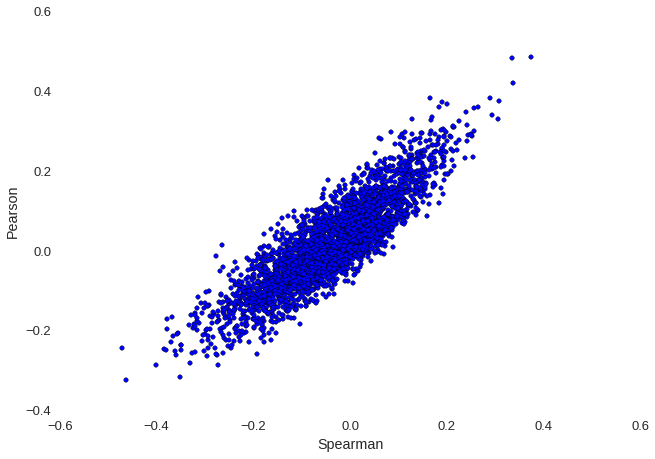

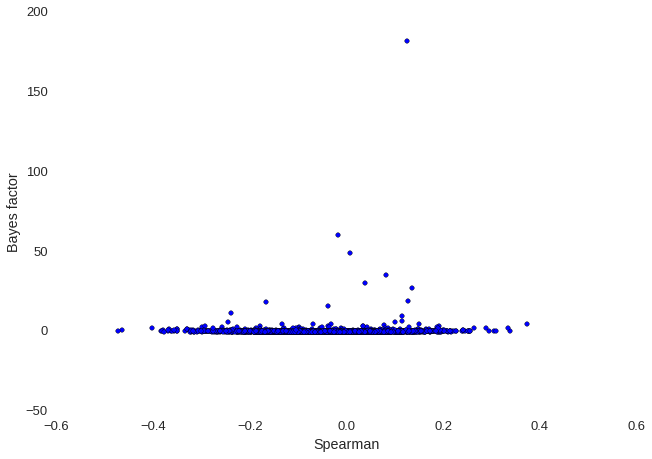

In [210]:
plt.scatter(bf.ix[:,1], bf.ix[:,2])
plt.xlabel("Spearman")
plt.ylabel("Pearson")
plt.show()

plt.scatter(bf.ix[:,1], bf.ix[:,0])
plt.xlabel("Spearman")
plt.ylabel("Bayes factor")
plt.show()

##Outliers

In [180]:
def get_outliers(df, key, num_std):
    if key == "bf":
        key = 0
    elif key == "rho":
        key = 1  
    outliers = {}   
    ai = 0
    for i in xrange(key, len(df.columns), 3):
        d = df.ix[:,i]
        d_std = np.std(d)
        d_mean = np.mean(d)
        cutoffs = [d_mean + (num_std*d_std), d_mean - (num_std*d_std)]
        env = ai_cols[ai]
        outliers[env] = d[(d >= cutoffs[0]) | (d <= cutoffs[1])]
        ai += 1
    return outliers

In [181]:
def plot_outliers(df, key, num_std):
    if key == "bf":
        key = 0
    elif key == "rho":
        key = 1   
    ai = 0
    for i in xrange(key, len(df.columns), 3):
        d = df.ix[:,i]
        d_std = np.std(d)
        d_mean = np.mean(d)
        env = ai_cols[ai]
        ax = plt.gca()
        if key == 0:
            ax.set_yscale('log')
        plt.hist(d, bins=100)
        plt.xlim(np.min(d), d_mean+(num_std*d_std))
        plt.title("%s $\mu = %.4f \pm %.4f [%.4f, %.4f])$" % (env,
                                                            d_mean,
                                                            d_std,
                                                            np.min(d),
                                                            np.max(d)))
        plt.show()
        ai += 1

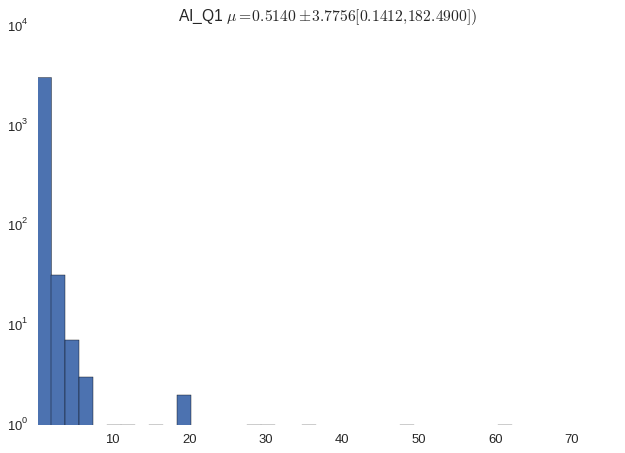

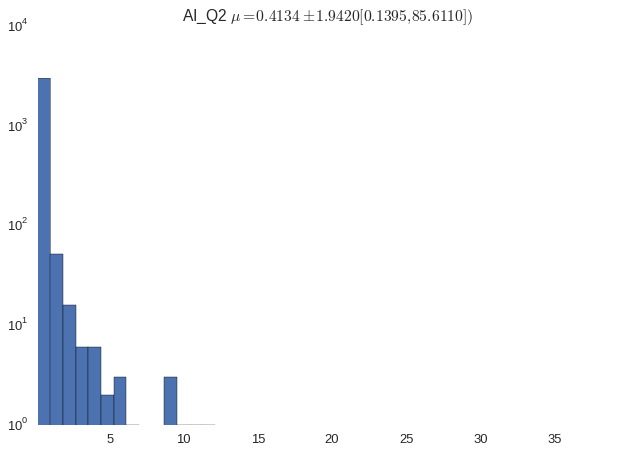

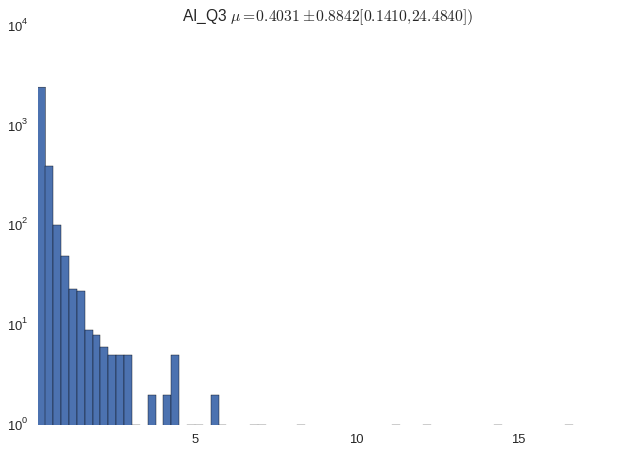

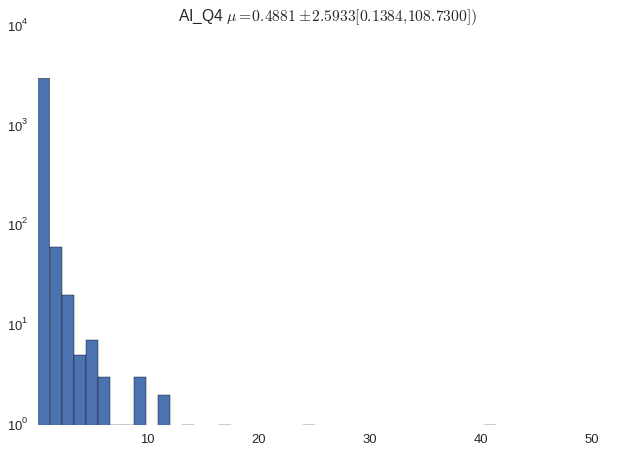

In [182]:
plot_outliers(bf, "bf", 20)

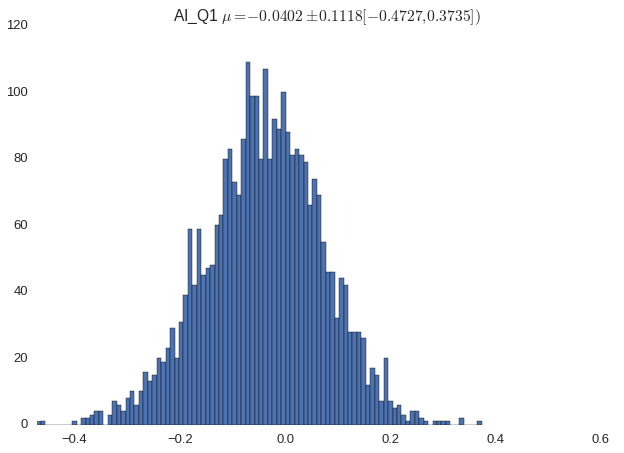

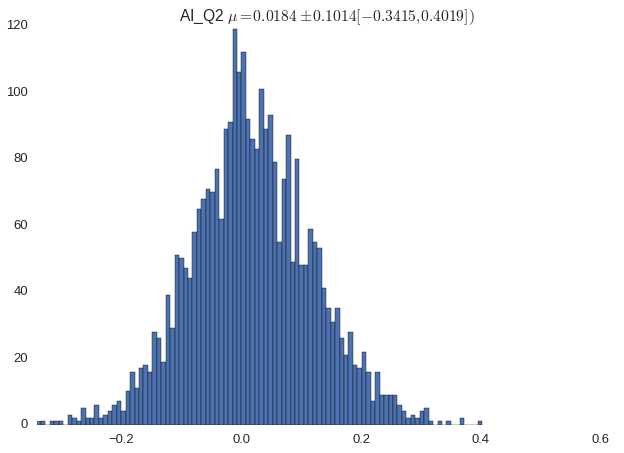

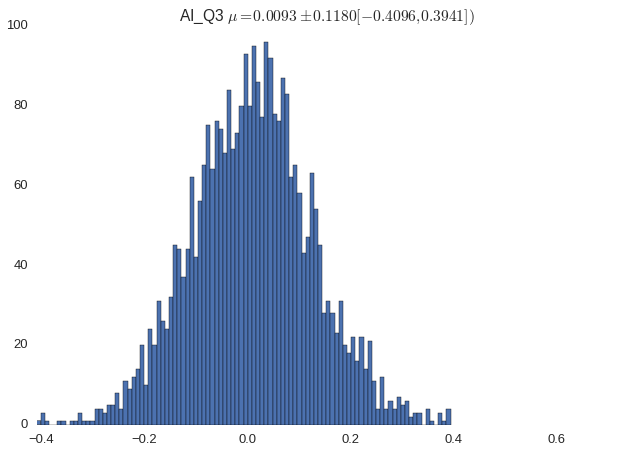

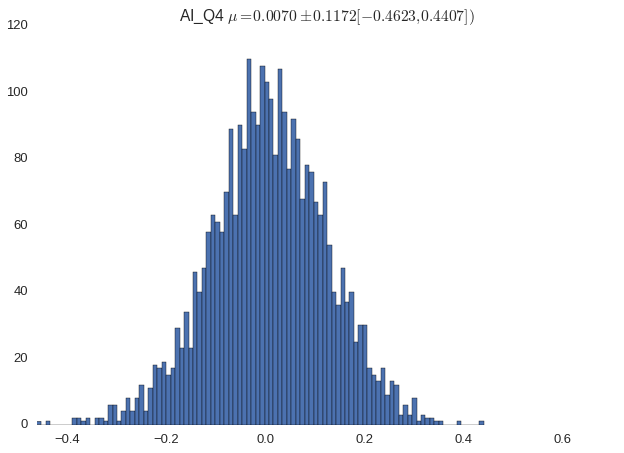

In [183]:
plot_outliers(bf, "rho", 6)

In [184]:
bf_outliers = get_outliers(bf, "bf", 6)    
rho_outliers = get_outliers(bf, "rho", 3)

In [185]:
bf_outliers.keys()

[u'AI_Q3', u'AI_Q2', u'AI_Q1', u'AI_Q4']

In [186]:
rho_outliers.keys()

[u'AI_Q3', u'AI_Q2', u'AI_Q1', u'AI_Q4']

In [187]:
%%R
library(VennDiagram)

Loading required package: grid


In [188]:
def draw_venn(outliers, title):
    keys = sorted(list(outliers.keys()))
    a1 = set(outliers[keys[0]].index)
    a2 = set(outliers[keys[1]].index)
    a3 = set(outliers[keys[2]].index)
    a4 = set(outliers[keys[3]].index)
    area1 = len(a1)
    area2 = len(a2)
    area3 = len(a3) 
    area4 = len(a4)
    n12 = len(a1.intersection(a2))
    n13 = len(a1.intersection(a3))
    n14 = len(a1.intersection(a4))
    n23 = len(a2.intersection(a3))
    n24 = len(a2.intersection(a4))
    n34 = len(a3.intersection(a4))
    n123 = len(set.intersection(a1, a2, a3))
    n124 = len(set.intersection(a1, a2, a4))
    n134 = len(set.intersection(a1, a3, a4))
    n234 = len(set.intersection(a2, a3, a4))
    n1234 = len(set.intersection(a1, a2, a3, a4))
    venn = "venn_%s.png" % title.replace(" ", "_")
    r("library(VennDiagram)")
    r("png('%s')" % venn)
    r('draw.quad.venn')(area1, 
                  area2,
                  area3,
                  area4,
                  n12,
                  n13,
                  n14,
                  n23,
                  n24,
                  n34,
                  n123,
                  n124,
                  n134,
                  n234,
                  n1234,
                       category=keys)
    r('dev.off()')
    return venn

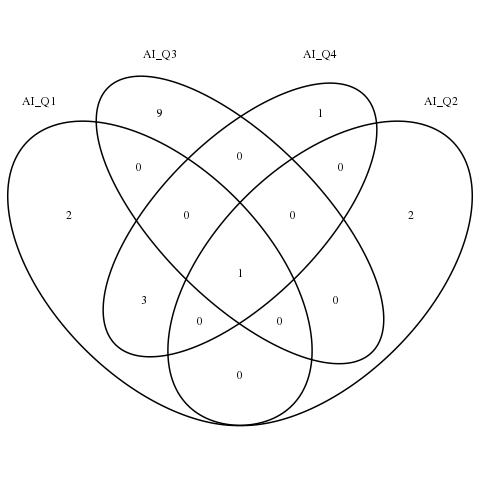

In [189]:
Image(draw_venn(bf_outliers, "Bayes factor outliers"))

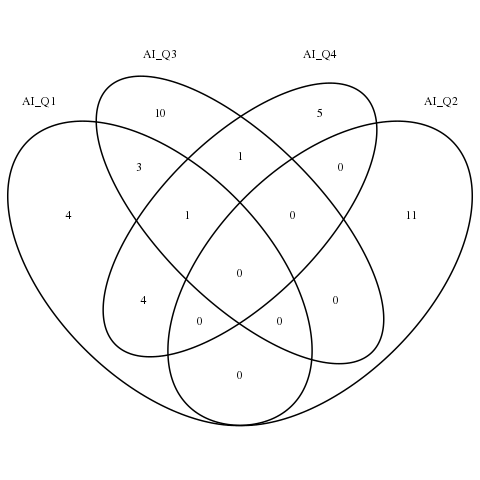

In [190]:
Image(draw_venn(rho_outliers, "Rho outliers"))

In [191]:
combined_outliers = {}
for key in bf_outliers:
    a = bf_outliers[key].index
    b = rho_outliers[key].index
    combined_outliers[key] = pd.Series(index=a.intersection(b))

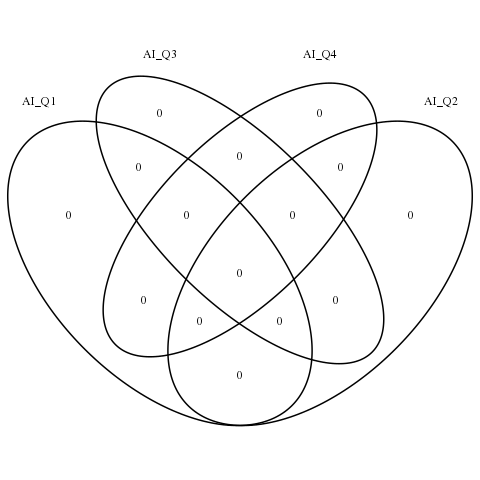

In [192]:
Image(draw_venn(combined_outliers, "combined"))

In [193]:
boxplot_data = {}
for key, val in bf_outliers.items():
    val = val.sort(inplace=False, ascending=False)
    boxplot_data[key] = {val.index[0]: val[0]}

In [194]:
boxplot_data

{u'AI_Q1': {'0-11252-01-353': 182.49000000000001},
 u'AI_Q2': {'2-10309-01-389': 85.611000000000004},
 u'AI_Q3': {'2-10390-01-65': 24.484000000000002},
 u'AI_Q4': {'UMN-6288-01-39': 108.73}}

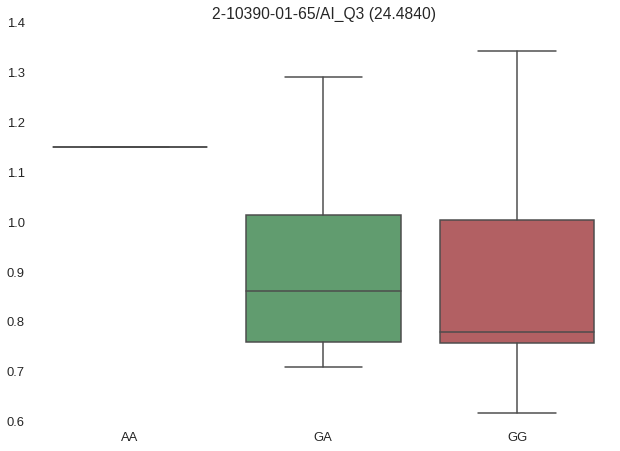

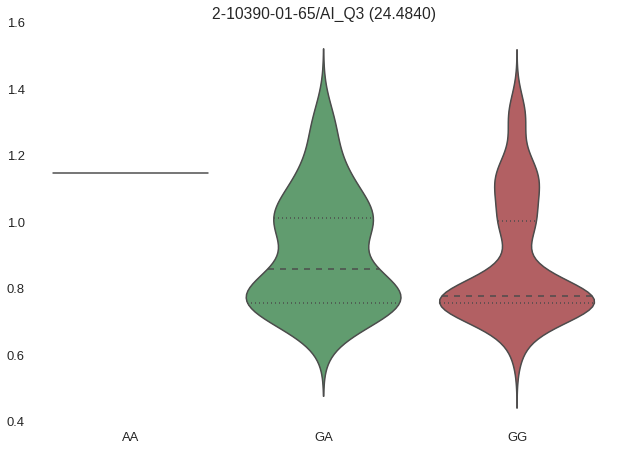

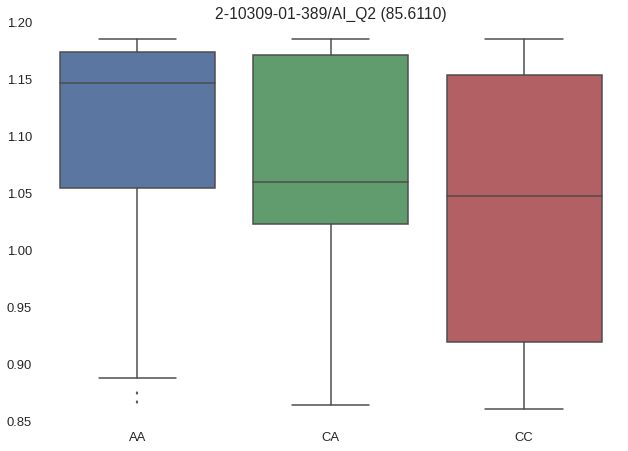

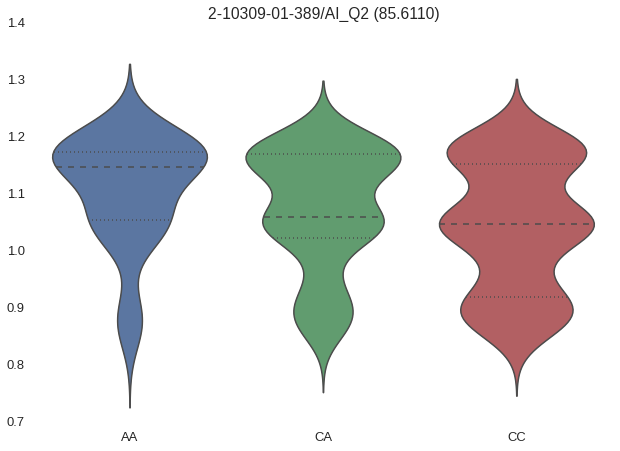

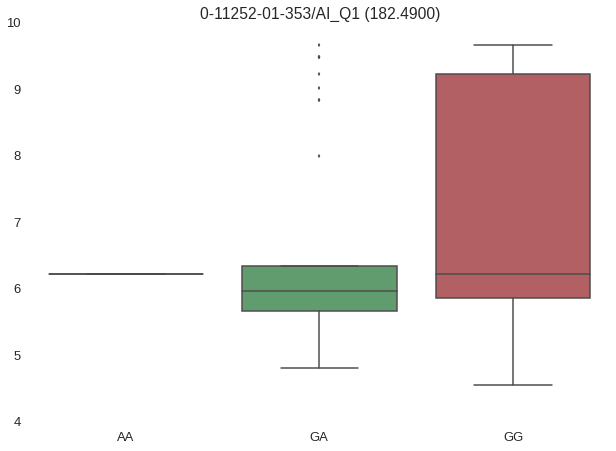

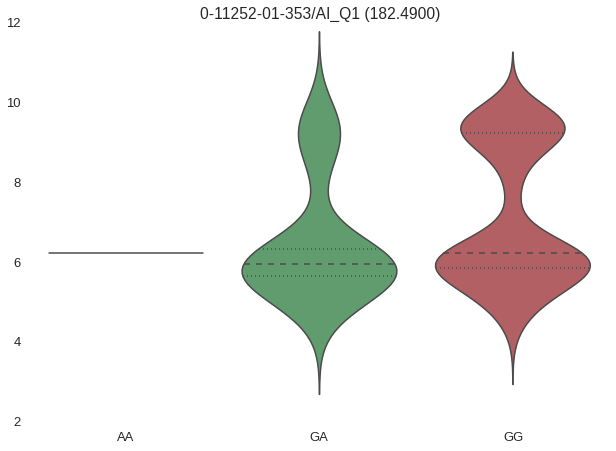

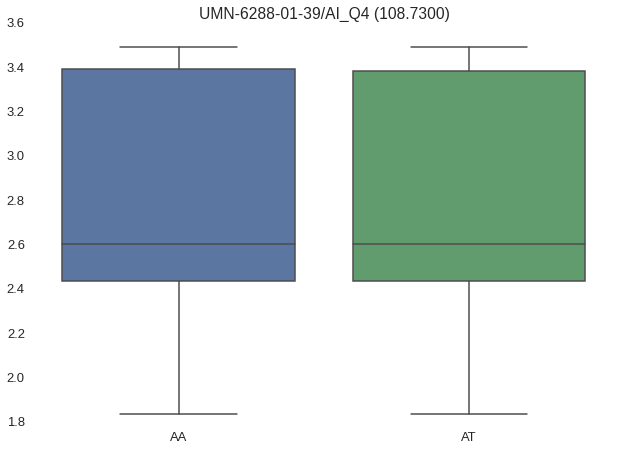

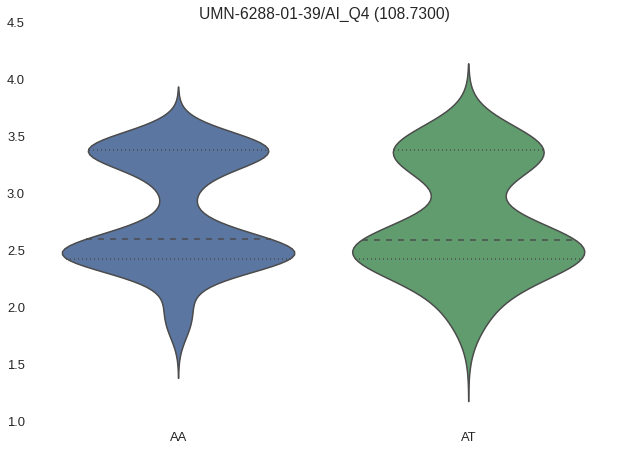

In [196]:
bayenv_df_ai_basegt = bayenv_df_ai.apply(convert_to_snpassoc)
for env in boxplot_data:
    for snp in boxplot_data[env]:
        vals = {}
        for gt, group in bayenv_df_ai_basegt.groupby(snp):
            if not gt == 'NA':
                vals[gt.replace("/", "")] = group[env]
        vals = pd.DataFrame(vals, dtype=float)
        vals.index.name = env

        sns.boxplot([vals[x].dropna() for x in vals], 
                    names=vals.columns)
        plt.title("%s/%s (%.4f)" % (snp, vals.index.name, boxplot_data[env][snp]))
        plt.show()

        sns.violinplot([vals[x].dropna() for x in vals], 
                    names=vals.columns)
        plt.title("%s/%s (%.4f)" % (snp, vals.index.name, boxplot_data[env][snp]))
        plt.show()